# Team Based Model

## Imports

In [124]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr

from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [8]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [10]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53811  2021-22  1610612752               NYK         New York Knicks   
53812  2021-22  1610612742               DAL        Dallas Mavericks   
53813  2021-22  1610612759               SAS       San Antonio Spurs   
53814  2021-22  1610612744               GSW   Golden State Warriors   
53815  2021-22  1610612763               MEM       Memphis Grizzlies   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53811  0022100067 2021-10-28    NYK @ CHI   1  240   39   85   0.459    11   
53812  0022100069 2021-10-28  DAL vs. SAS   1  240   41   89   0.461    18   
53813  0022100069 2021-10-28    SAS @ DAL   0  240   39   88   0.443    12   
53814  0022100070 2021-10-28  GSW vs. MEM   0  265   39   90   0.433    14   
53815  0022100070 2021-10-28    MEM @ GSW   1  265   39   97   0.402    12   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53811    29    0.379   15   20   0.750    11    38   49   16    5    7   13   
53812    45    0.400    4   13   0.308     9    36   45   18    4    7   13   
53813    30    0.400    9   15   0.600    11    37   48   21    6   11   15   
53814    40    0.350    9   12   0.750     7    41   48   29    8    7   23   
53815    48    0.250   14   14   1.000    10    41   51   25   17    9   18   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53811  21  104           1         108.6       110.6         107.7   
53812  19  104           5         105.3       108.3         100.4   
53813  16   99          -5         100.4       103.1         105.3   
53814  17  101          -3          90.8        93.5          93.6   
53815  14  104           3          93.6        95.4          90.8   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [11]:
from src.data.make_team_dataset import prep_for_aggregation


def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

#     df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
#                             'PCT_PTS_3PT', 'PCT_PTS_FB',
#                             'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
#                             'PCT_AST_2PM', 'PCT_UAST_2PM',
#                             'PCT_AST_3PM', 'PCT_UAST_3PM',
#                             'PCT_AST_FGM', 'PCT_UAST_FGM',
#                             'FGM', 'FGA'])

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53811  2021-22  1610612752               NYK         New York Knicks   
53812  2021-22  1610612742               DAL        Dallas Mavericks   
53813  2021-22  1610612759               SAS       San Antonio Spurs   
53814  2021-22  1610612744               GSW   Golden State Warriors   
53815  2021-22  1610612763               MEM       Memphis Grizzlies   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53811  0022100067 2021-10-28    NYK @ CHI          0         104           1   
53812  0022100069 2021-10-28  DAL vs. SAS          1         104           5   
53813  0022100069 2021-10-28    SAS @ DAL          0          99          -5   
53814  0022100070 2021-10-28  GSW vs. MEM          1         101          -3   
53815  0022100070 2021-10-28    MEM @ GSW          0         104           3   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53811   1       1    28    56    11    29   15   20    11    38   49   16   
53812   1       1    23    44    18    45    4   13     9    36   45   18   
53813   0       0    27    58    12    30    9   15    11    37   48   21   
53814   0       0    25    50    14    40    9   12     7    41   48   29   
53815   1       1    27    49    12    48   14   14    10    41   51   25   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53811    5    7   13  21  104           1         108.6       110.6   
53812    4    7   13  19  104           5         105.3       108.3   
53813    6   11   15  16   99          -5         100.4       103.1   
53814    8    7   23  17  101          -3          90.8        93.5   
53815   17    9   18  14  104           3          93.6        95.4   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

## Add Betting Data 

In [12]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [13]:
spreads

SEASON     GM_DATE      HOME_TEAM    AWAY_TEAM    AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami      Chicago    22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers      Phoenix    41,17,21,27,106   
2      2006-07  2006-11-02         Dallas  San Antonio     26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers       Denver     24,24,22,25,95   
4      2006-07  2006-11-03        Memphis    Charlotte     21,26,23,13,83   
...        ...         ...            ...          ...                ...   
18950  2021-22  2021-10-28     Washington      Atlanta    32,23,31,25,111   
18951  2021-22  2021-10-28        Chicago     New York    27,28,27,22,104   
18952  2021-22  2021-10-28        Houston         Utah    32,29,31,30,122   
18953  2021-22  2021-10-28         Dallas  San Antonio     25,24,27,23,99   
18954  2021-22  2021-10-28   Golden State      Memphis  20,25,28,25,6,104   

         HOME_SCOREBOARD                AWAY_SPREAD                HOME_SPREAD  
0         16,14,21,15,66              -,-,+4½-110,-              -,-,-4½-110,-  
1        26,27,34,27,114              -,-,-8½-110,-              -,-,+8½-110,-  
2         27,24,24,16,91               -,-,+3-110,-               -,-,-3-110,-  
3         18,31,16,31,96              -,-,+4½-110,-              -,-,-4½-110,-  
4         24,20,16,36,96               -,-,+5-110,-               -,-,-5-110,-  
...                  ...                        ...                        ...  
18950    33,31,36,22,122    -4-115,-,-2½-108,-6+120    +4-105,-,+2½-114,+6-165  
18951    25,26,22,30,103    +1-110,-,+1½-110,+3-145    -1-110,-,-1½-112,-3+105  
18952     18,22,32,19,91   -9½-110,-,-9-110,-8½-135   +9½-110,-,+9-110,+8½-105  
18953    15,32,29,28,104  +6½-110,-,+6½-110,+6½-110  -6½-110,-,-6½-110,-8½+130  
18954  37,18,24,19,3,101     +6-110,-,+6-110,+6-110     -6-110,-,-6-110,-8+125  

[18955 rows x 8 columns]

In [14]:
moneylines

SEASON     GM_DATE     HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22      Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22   L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23     Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23       Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23       Orlando          Miami  -195,-195,-210,-   
...        ...         ...           ...            ...               ...   
18948  2021-22  2021-10-28    Washington        Atlanta  -170,-,-130,-180   
18949  2021-22  2021-10-28       Chicago       New York  +100,-,+102,+100   
18950  2021-22  2021-10-28       Houston           Utah  -450,-,-420,-450   
18951  2021-22  2021-10-28        Dallas    San Antonio  +210,-,+215,+210   
18952  2021-22  2021-10-28  Golden State        Memphis  +200,-,+205,+195   

                HOME_ML  
0      -360,-330,-350,-  
1      -130,-130,-140,-  
2      +135,+136,+135,-  
3      -330,-370,-330,-  
4      +170,+170,+175,-  
...                 ...  
18948  +150,-,+110,+150  
18949  -120,-,-121,-120  
18950  +350,-,+320,+340  
18951  -250,-,-265,-265  
18952  -240,-,-250,-245  

[18953 rows x 6 columns]

In [15]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [16]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [17]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [18]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [19]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered


In [20]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
18950  2021-22  2021-10-28       WAS       ATL                  6.0   
18951  2021-22  2021-10-28       CHI       NYK                 -3.0   
18952  2021-22  2021-10-28       HOU       UTA                  9.5   
18953  2021-22  2021-10-28       DAL       SAS                 -8.5   
18954  2021-22  2021-10-28       GSW       MEM                 -8.0   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
18950                 -6.0  
18951                  3.0  
18952                 -9.5  
18953                  6.5  
18954                  6.0  

[18955 rows x 6 columns]

In [21]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
18948  2021-22  2021-10-28       WAS       ATL         2.500000   
18949  2021-22  2021-10-28       CHI       NYK         1.826446   
18950  2021-22  2021-10-28       HOU       UTA         4.500000   
18951  2021-22  2021-10-28       DAL       SAS         1.377358   
18952  2021-22  2021-10-28       GSW       MEM         1.400000   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
18948         1.555556  
18949         2.020000  
18950         1.222222  
18951         3.150000  
18952         3.050000  

[18953 rows x 6 columns]

In [22]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [23]:
merged_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53809  2021-22  1610612752               NYK         New York Knicks   
53810  2021-22  1610612742               DAL        Dallas Mavericks   
53811  2021-22  1610612759               SAS       San Antonio Spurs   
53812  2021-22  1610612744               GSW   Golden State Warriors   
53813  2021-22  1610612763               MEM       Memphis Grizzlies   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53809  0022100067 2021-10-28    NYK @ CHI          0         104           1   
53810  0022100069 2021-10-28  DAL vs. SAS          1         104           5   
53811  0022100069 2021-10-28    SAS @ DAL          0          99          -5   
53812  0022100070 2021-10-28  GSW vs. MEM          1         101          -3   
53813  0022100070 2021-10-28    MEM @ GSW          0         104           3   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53809   1       1    28    56    11    29   15   20    11    38   49   16   
53810   1       1    23    44    18    45    4   13     9    36   45   18   
53811   0       0    27    58    12    30    9   15    11    37   48   21   
53812   0       0    25    50    14    40    9   12     7    41   48   29   
53813   1       1    27    49    12    48   14   14    10    41   51   25   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53809    5    7   13  21  104           1         108.6       110.6   
53810    4    7   13  19  104           5         105.3       108.3   
53811    6   11   15  16   99          -5         100.4       103.1   
53812    8    7   23  17  101          -3          90.8        93.5   
53813   17    9   18  14  104           3          93.6        95.4   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

In [24]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [25]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107618     2021-22    1610612752                    NYK   
107621     2021-22    1610612742                    DAL   
107622     2021-22    1610612759                    SAS   
107625     2021-22    1610612744                    GSW   
107626     2021-22    1610612763                    MEM   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107618         New York Knicks  0022100067     2021-10-28    NYK @ CHI   
107621        Dallas Mavericks  0022100069     2021-10-28  DAL vs. SAS   
107622       San Antonio Spurs  0022100069     2021-10-28    SAS @ DAL   
107625   Golden State Warriors  0022100070     2021-10-28  GSW vs. MEM   
107626       Memphis Grizzlies  0022100070     2021-10-28    MEM @ GSW   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107618               0              104                1        1   
107621               1              104                5        1   
107622               0               99               -5        0   
107625               1              101               -3        0   
107626               0              104                3        1   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107618            1         28         56         11         29        15   
107621            1         23         44         18         45         4   
107622            0         27         58         12         30         9   
107625            0         25         50         14         40         9   
107626            1         27         49         12         48        14   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107618        20         11         38        49        16         5   
107621        13          9         36        45        18         4   
107622 

In [26]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:20<00:00,  1.07it/s]


In [27]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53809     2021-22    1610612740                    NOP  New Orleans Pelicans   
53810     2021-22    1610612740                    NOP  New Orleans Pelicans   
53811     2021-22    1610612740                    NOP  New Orleans Pelicans   
53812     2021-22    1610612740                    NOP  New Orleans Pelicans   
53813     2021-22    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53809  0022100009     2021-10-20  NOP vs. PHI               1   
53810  0022100022     2021-10-22    NOP @ CHI               0   
53811  0022100031     2021-10-23    NOP @ MIN               0   
53812  0022100047     2021-10-25    NOP @ MIN               0   
53813  0022100059     2021-10-27  NOP vs. ATL               1   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53809               97              -20        0     2.50          4.5   
53810              112              -16        0     3.30          7.0   
53811               89               -7        0     3.40          9.5   
53812              107                9        1     2.85          6.0   
53813               99               -3        0     2.85          6.0   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0     1.000000  30.000000  71.000000   2.000000   
2                      0     1.000000  35.263158  76.789474   0.947368   
3                      0     1.000000  33.321033  69.856089   0.966790   
4                      0     1.000000  33.809247  68.444024   2.430358   
...                  ...          ...        ...        ...        ...   
53809                  0          NaN        NaN        NaN        NaN   
53810                  0     0.000000  26.000000  63.000000  13.000000   
53811                  1     0.000000  26.526316  60.368421  14.052632   
53812                  1     0.000000  24.856089  56.173432  12.188192   
53813                  1     0.290782  26.061064  56.413783  11.551905   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       7.000000  20.000000  32.000000  11.000000  41.000000  52.000000   
2       5.421053  21.052632  30.421053  14.157895  37.315789  51.473684   
3       6.741697  23.616236  32.848708  12.623616  34.616236  47.239852   
4       6.816807  19.947659  29.403315  11.569933  30.075313  41.645246   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [28]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [29]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [30]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [31]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
0      2000-01  1610612755               PHI     Philadelphia 76ers   
1      2000-01  1610612752               NYK        New York Knicks   
2      2000-01  1610612739               CLE    Cleveland Cavaliers   
3      2000-01  1610612751               BKN        New Jersey Nets   
4      2000-01  1610612764               WAS     Washington Wizards   
...        ...         ...               ...                    ...   
53809  2021-22  1610612745               HOU        Houston Rockets   
53810  2021-22  1610612759               SAS      San Antonio Spurs   
53811  2021-22  1610612742               DAL       Dallas Mavericks   
53812  2021-22  1610612763               MEM      Memphis Grizzlies   
53813  2021-22  1610612744               GSW  Golden State Warriors   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53809  0022100068 2021-10-28  HOU vs. UTA          1          91   
53810  0022100069 2021-10-28    SAS @ DAL          0          99   
53811  0022100069 2021-10-28  DAL vs. SAS          1         104   
53812  0022100070 2021-10-28    MEM @ GSW          0         104   
53813  0022100070 2021-10-28  GSW vs. MEM          1         101   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53809              -31        0  4.500000          9.5                  0   
53810               -5        0  3.150000          8.5                  1   
53811                5        1  1.377358         -8.5                  0   
53812                3        1  3.050000          8.0                  1   
53813               -3        0  1.400000         -8.0                  0   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53809         -0.764466       -2.578222        3.937941        0.726025   
53810         -0.489127       10.971891       15.517332       -2.396947   
53811          0.489127      -10.971891      -15.517332        2.396947   
53812         -0.552486        0.796162        5.407677        0.872347   
53813          0.552486       -0.796162       -5.407677       -0.872347   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
53809       -6.

## Add ELO Rating

In [32]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [33]:
# full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
#                             'SEASON_ID_team':'SEASON_ID',
#                             'TEAM_ID_team': 'TEAM_ID',
#                             'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
#                             'TEAM_NAME_team': 'TEAM_NAME',
#                             'GAME_DATE_team': 'GAME_DATE',
#                             'MATCHUP_team': 'MATCHUP',
#                             'HOME_GAME_team': 'HOME_GAME',
#                             'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [34]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [35]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

progress:: 53814it [02:03, 437.10it/s]


In [36]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
0      2000-01  1610612755               PHI     Philadelphia 76ers   
1      2000-01  1610612752               NYK        New York Knicks   
2      2000-01  1610612739               CLE    Cleveland Cavaliers   
3      2000-01  1610612751               BKN        New Jersey Nets   
4      2000-01  1610612764               WAS     Washington Wizards   
...        ...         ...               ...                    ...   
53809  2021-22  1610612745               HOU        Houston Rockets   
53810  2021-22  1610612759               SAS      San Antonio Spurs   
53811  2021-22  1610612742               DAL       Dallas Mavericks   
53812  2021-22  1610612763               MEM      Memphis Grizzlies   
53813  2021-22  1610612744               GSW  Golden State Warriors   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53809  0022100068 2021-10-28  HOU vs. UTA          1          91   
53810  0022100069 2021-10-28    SAS @ DAL          0          99   
53811  0022100069 2021-10-28  DAL vs. SAS          1         104   
53812  0022100070 2021-10-28    MEM @ GSW          0         104   
53813  0022100070 2021-10-28  GSW vs. MEM          1         101   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53809              -31        0  4.500000          9.5                  0   
53810               -5        0  3.150000          8.5                  1   
53811                5        1  1.377358         -8.5                  0   
53812                3        1  3.050000          8.0                  1   
53813               -3        0  1.400000         -8.0                  0   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53809         -0.764466       -2.578222        3.937941        0.726025   
53810         -0.489127       10.971891       15.517332       -2.396947   
53811          0.489127      -10.971891      -15.517332        2.396947   
53812         -0.552486        0.796162        5.407677        0.872347   
53813          0.552486       -0.796162       -5.407677       -0.872347   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
53809       -6.

In [37]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

In [38]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

{'MIL': 1728.3633862833926,
 'PHX': 1719.5375580768125,
 'LAC': 1697.9465766106773,
 'UTA': 1679.950559925344,
 'PHI': 1661.3481248151209,
 'BKN': 1660.3020409855592,
 'DEN': 1613.7815626338604,
 'POR': 1612.3491677106474,
 'ATL': 1595.7093515943002,
 'LAL': 1566.8313196978793,
 'DAL': 1565.643688070191,
 'NYK': 1562.349322237786,
 'GSW': 1544.2762089443431,
 'MEM': 1543.8515399762978,
 'MIA': 1517.7969526315635,
 'BOS': 1493.8585537183362,
 'CHI': 1479.594002983012,
 'IND': 1478.5440665487745,
 'WAS': 1469.2351122552523,
 'SAS': 1464.1243150098553,
 'NOP': 1459.5087263936541,
 'TOR': 1438.3069260920208,
 'SAC': 1435.9282200085781,
 'CHA': 1416.6217041038497,
 'MIN': 1394.0312381538074,
 'DET': 1317.853574213266,
 'CLE': 1276.9765081239782,
 'HOU': 1266.4192978976585,
 'ORL': 1252.3135857552807,
 'OKC': 1216.63822299864}

## Helper Functions for Bet Simulations

In [42]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [43]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [44]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

In [45]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [46]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

## Create Features Sets

### Features EWM

In [47]:
cutoff_16 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2015-16'].index[-1]
cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].index[-1]
cutoff_22 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].index[-1]

In [48]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['POINT_DIFF_team'] + df['SPREAD_team'] != 0]

    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:]
    features['SPREAD_team'] = df['SPREAD_team']
    features['ML_team'] = df['ML_team']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['TEAM_COVERED_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [49]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_16)


In [50]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.6301115806755647


RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [51]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
0      2000-01  1610612755               PHI     Philadelphia 76ers   
1      2000-01  1610612752               NYK        New York Knicks   
2      2000-01  1610612739               CLE    Cleveland Cavaliers   
3      2000-01  1610612751               BKN        New Jersey Nets   
4      2000-01  1610612764               WAS     Washington Wizards   
...        ...         ...               ...                    ...   
53809  2021-22  1610612745               HOU        Houston Rockets   
53810  2021-22  1610612759               SAS      San Antonio Spurs   
53811  2021-22  1610612742               DAL       Dallas Mavericks   
53812  2021-22  1610612763               MEM      Memphis Grizzlies   
53813  2021-22  1610612744               GSW  Golden State Warriors   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53809  0022100068 2021-10-28  HOU vs. UTA          1          91   
53810  0022100069 2021-10-28    SAS @ DAL          0          99   
53811  0022100069 2021-10-28  DAL vs. SAS          1         104   
53812  0022100070 2021-10-28    MEM @ GSW          0         104   
53813  0022100070 2021-10-28  GSW vs. MEM          1         101   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53809              -31        0  4.500000          9.5                  0   
53810               -5        0  3.150000          8.5                  1   
53811                5        1  1.377358         -8.5                  0   
53812                3        1  3.050000          8.0                  1   
53813               -3        0  1.400000         -8.0                  0   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53809         -0.764466       -2.578222        3.937941        0.726025   
53810         -0.489127       10.971891       15.517332       -2.396947   
53811          0.489127      -10.971891      -15.517332        2.396947   
53812         -0.552486        0.796162        5.407677        0.872347   
53813          0.552486       -0.796162       -5.407677       -0.872347   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
53809       -6.

### Define Custom Scorer

In [52]:
tscv = TimeSeriesSplit()

In [53]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [54]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=10000,
                                                 verbose=1))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lr2'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

[I 2021-10-29 12:04:55,081] Using an existing study with name 'study_lr2' instead of creating a new one.
[I 2021-10-29 12:05:04,329] Trial 503 finished with value: 0.5260567458019687 and parameters: {'C': 0.06597346565574339}. Best is trial 369 with value: 0.5266936884771279.


In [55]:
study_lr.trials_dataframe().sort_values(['value'])

number     value             datetime_start          datetime_complete  \
11       11  0.506732 2021-10-10 23:22:30.264463 2021-10-10 23:22:31.424914   
69       69  0.506914 2021-10-10 23:27:33.099483 2021-10-10 23:27:34.070239   
468     468  0.511175 2021-10-28 23:04:21.748721 2021-10-28 23:04:22.771685   
87       87  0.513859 2021-10-10 23:28:01.966007 2021-10-10 23:28:03.016391   
18       18  0.516296 2021-10-10 23:23:09.057410 2021-10-10 23:23:10.209265   
..      ...       ...                        ...                        ...   
480     480  0.526636 2021-10-28 23:06:32.523735 2021-10-28 23:06:38.714556   
477     477  0.526636 2021-10-28 23:06:15.286260 2021-10-28 23:06:21.653079   
372     372  0.526636 2021-10-28 17:11:52.426221 2021-10-28 17:11:59.261260   
369     369  0.526694 2021-10-28 17:11:27.639190 2021-10-28 17:11:34.507903   
0         0       NaN 2021-10-10 21:55:07.421809                        NaT   

                  duration  params_C     state  
11  0 days 00:00:01.160451  0.000016  COMPLETE  
69  0 days 00:00:00.970756  0.000011  COMPLETE  
468 0 days 00:00:01.022964  0.000017  COMPLETE  
87  0 days 00:00:01.050384  0.000037  COMPLETE  
18  0 days 00:00:01.151855  0.000071  COMPLETE  
..                     ...       ...       ...  
480 0 days 00:00:06.190821  0.061883  COMPLETE  
477 0 days 00:00:06.366819  0.062523  COMPLETE  
372 0 days 00:00:06.835039  0.061882  COMPLETE  
369 0 days 00:00:06.868713  0.062268  COMPLETE  
0                      NaT  0.000490   RUNNING  

[504 rows x 7 columns]

0.06226787404081285


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 168 epochs took 5 seconds
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.06226787404081285, max_iter=100000,
                                    random_state=23, solver='saga',
                                    verbose=1))])
train_acc: 0.5470687575392038
test_acc: 0.508301824757521


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


feature_name      coef
79     AST_RATIO_team_diff -0.329016
41            AST_opp_diff -0.185019
10           AST_team_diff -0.149380
59       UAST_2PM_opp_diff -0.142829
37            FTA_opp_diff -0.141927
2           FG2A_team_diff -0.136555
28      UAST_2PM_team_diff -0.132109
77       EFG_PCT_team_diff -0.111163
5            FTM_team_diff -0.104231
29      UAST_3PM_team_diff -0.091219
7           OREB_team_diff -0.090618
54         PTS_FB_opp_diff -0.085542
35           FG3A_opp_diff -0.083739
65         AVG_SPREAD_diff -0.082733
75        TS_PCT_team_diff -0.082293
56      PTS_PAINT_opp_diff -0.077864
45             PF_opp_diff -0.072733
34           FG3M_opp_diff -0.068615
52            PIE_opp_diff -0.068368
67       AVG_ATS_DIFF_diff -0.068225
16    PLUS_MINUS_team_diff -0.065942
38           OREB_opp_diff -0.064482
0         RECORD_team_diff -0.049995
61       ATS_DIFF_opp_diff -0.043670
13           TOV_team_diff -0.041938
57        AST_2PM_opp_diff -0.040384
12           BLK_team_diff -0.040025
76         TS_PCT_opp_diff -0.035519
71      DREB_PCT_team_diff -0.031538
72       DREB_PCT_opp_diff -0.029421
74        REB_PCT_opp_diff -0.026675
53     PTS_2PT_MR_opp_diff -0.023725
55    PTS_OFF_TOV_opp_diff -0.022009
86            elo_MOV_pred -0.020972
50   E_NET_RATING_opp_diff -0.017282
4           FG3A_team_diff -0.015673
84           team_rating_i -0.015416
15           PTS_team_diff -0.011227
80      AST_RATIO_opp_diff -0.002238
40            REB_opp_diff  0.000157
88                 ML_team  0.001247
20          POSS_team_diff  0.001419
43            BLK_opp_diff  0.007229
85            opp_rating_i  0.015793
19  E_NET_RATING_team_diff  0.017282
3           FG3M_team_diff  0.017288
60       UAST_3PM_opp_diff  0.019090
11           STL_team_diff  0.019899
51           POSS_opp_diff  0.020903
68               REST_diff  0.021239
1           FG2M_team_diff  0.024956
73       REB_PCT_team_diff  0.026675
66             AVG_ML_diff  0.027541
22    PTS_2PT_MR_team_diff  0.029227
23        PTS_FB_team_diff  0.029378
69      OREB_PCT_team_diff  0.029421
70       OREB_PCT_opp_diff  0.031538
63             WL_PCT_diff  0.032462
9            REB_team_diff  0.033173
44            TOV_opp_diff  0.036470
33           FG2A_opp_diff  0.039815
14            PF_team_diff  0.042397
39           DREB_opp_diff  0.042429
30      ATS_DIFF_team_diff  0.043670
64            ATS_PCT_diff  0.045494
31         RECORD_opp_diff  0.049995
25     PTS_PAINT_team_diff  0.054540
81       TOV_PCT_team_diff  0.054958
82        TOV_PCT_opp_diff  0.060580
24   PTS_OFF_TOV_team_diff  0.060949
46            PTS_opp_diff  0.061187
21           PIE_team_diff  0.064294
6            FTA_team_diff  0.064445
62   TEAM_COVERED_opp_diff  0.064724
47     PLUS_MINUS_opp_diff  0.065942
36            FTM_opp_diff  0.076406
42            STL_opp_diff  0.079032
78        EFG_PCT_opp_diff  0.081380
58        AST_3PM_opp_diff  0.082809
32           FG2M_opp_diff  0.088928
18  E_DEF_RATING_team_diff  0.107940
48   E_OFF_RATING_opp_diff  0.107940
8           DREB_team_diff  0.117256
17  E_OFF_RATING_team_diff  0.131549
49   E_DEF_RATING_opp_diff  0.131549
83           team_elo_pred  0.133844
87             SPREAD_team  0.159896
27       AST_3PM_team_diff  0.206363
26       AST_2PM_team_diff  0.320787

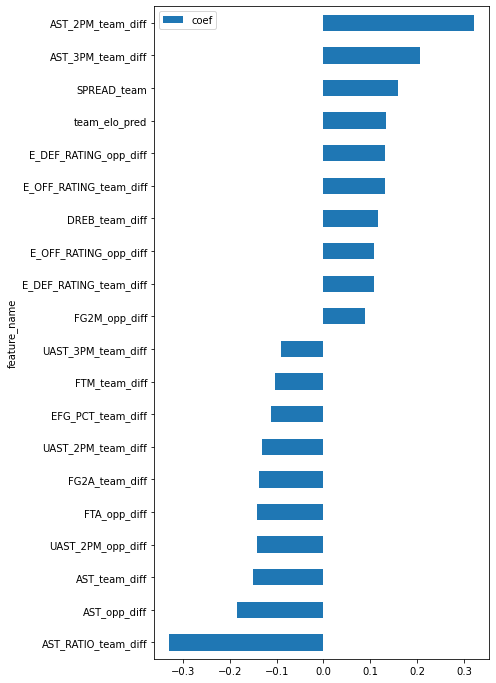

In [56]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train)

## SVC 

In [57]:
def objective(trial):    
    svc_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C = svc_C,
                                loss='hinge',
                               max_iter=100000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_svc_acc1'
storage_name = "sqlite:///{}.db".format(study_name)

study_svc_acc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_svc_acc.optimize(objective, n_trials=1)

[I 2021-10-29 12:05:10,310] Using an existing study with name 'study_svc_acc1' instead of creating a new one.
[I 2021-10-29 12:05:12,183] Trial 502 finished with value: 0.5225825130283728 and parameters: {'C': 0.04898541695559008}. Best is trial 92 with value: 0.5273225708193726.


In [84]:
svc_C = study_svc_acc.best_params['C']
print('C:', svc_C)
best_svc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C = svc_C,
                                loss='hinge',
                               max_iter=100000,
                                     random_state=23))]) 


best_svc.fit(X_train, y_train)

print("best_svc:", best_svc)


print("train_score:", best_svc.score(X_train, y_train))
print("test_score:", best_svc.score(X_test, y_test))

C: 0.05305927223792528
best_svc: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.05305927223792528, loss='hinge', max_iter=100000,
                           random_state=23))])
train_score: 0.5482267792521109
test_score: 0.5083840210422489


In [59]:
# svc_pipe_rbf = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', SVC(random_state=23, probability=True))])



# params = {
#     'svc__C': np.logspace(-3,1,100)
# }

# svc_rbf_cv = GridSearchCV(svc_pipe_rbf, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


# svc_rbf_cv.fit(X_train, y_train)

# best_svc_rbf = svc_rbf_cv.best_estimator_
# print("best_svc_rbf:", best_svc_rbf)


# print("train_score:", best_svc_rbf.score(X_train, y_train))
# print("test_score:", best_svc_rbf.score(X_test, y_test))

### SGD Hinge

In [60]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                               max_iter=10000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_sgd2'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=1)

[I 2021-10-29 12:05:13,835] Using an existing study with name 'study_sgd2' instead of creating a new one.
[I 2021-10-29 12:05:14,710] Trial 1102 finished with value: 0.5215402431962941 and parameters: {'alpha': 0.597989163881121}. Best is trial 101 with value: 0.5288455680779774.


0.5629982879384883
best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.5629982879384883, loss='modified_huber',
                               max_iter=10000, random_state=23))])
train_score: 0.5383835946924005
test_score: 0.5122472464244616


feature_name      coef
54         PTS_FB_opp_diff -0.028869
29      UAST_3PM_team_diff -0.021036
35           FG3A_opp_diff -0.019781
2           FG2A_team_diff -0.015407
45             PF_opp_diff -0.013339
0         RECORD_team_diff -0.013062
56      PTS_PAINT_opp_diff -0.011767
57        AST_2PM_opp_diff -0.011616
12           BLK_team_diff -0.011282
41            AST_opp_diff -0.009358
80      AST_RATIO_opp_diff -0.008438
22    PTS_2PT_MR_team_diff -0.007228
65         AVG_SPREAD_diff -0.006399
55    PTS_OFF_TOV_opp_diff -0.006270
74        REB_PCT_opp_diff -0.005916
67       AVG_ATS_DIFF_diff -0.005851
28      UAST_2PM_team_diff -0.005635
37            FTA_opp_diff -0.005577
32           FG2M_opp_diff -0.005460
16    PLUS_MINUS_team_diff -0.005387
70       OREB_PCT_opp_diff -0.004479
43            BLK_opp_diff -0.003732
15           PTS_team_diff -0.003557
1           FG2M_team_diff -0.003345
13           TOV_team_diff -0.002660
72       DREB_PCT_opp_diff -0.002548
85            opp_rating_i -0.002507
3           FG3M_team_diff -0.002414
79     AST_RATIO_team_diff -0.002096
38           OREB_opp_diff -0.001884
61       ATS_DIFF_opp_diff -0.001739
51           POSS_opp_diff -0.001171
19  E_NET_RATING_team_diff -0.001088
52            PIE_opp_diff -0.001033
40            REB_opp_diff -0.000638
10           AST_team_diff -0.000556
77       EFG_PCT_team_diff -0.000549
63             WL_PCT_diff  0.000131
39           DREB_opp_diff  0.000438
81       TOV_PCT_team_diff  0.000535
7           OREB_team_diff  0.000619
20          POSS_team_diff  0.000832
21           PIE_team_diff  0.001010
50   E_NET_RATING_opp_diff  0.001088
30      ATS_DIFF_team_diff  0.001739
46            PTS_opp_diff  0.002321
75        TS_PCT_team_diff  0.002536
69      OREB_PCT_team_diff  0.002548
59       UAST_2PM_opp_diff  0.002686
6            FTA_team_diff  0.002694
84           team_rating_i  0.002785
14            PF_team_diff  0.002832
26       AST_2PM_team_diff  0.003092
25     PTS_PAINT_team_diff  0.003318
68               REST_diff  0.003542
5            FTM_team_diff  0.003572
86            elo_MOV_pred  0.003995
66             AVG_ML_diff  0.004151
71      DREB_PCT_team_diff  0.004479
64            ATS_PCT_diff  0.004602
33           FG2A_opp_diff  0.004883
58        AST_3PM_opp_diff  0.005199
47     PLUS_MINUS_opp_diff  0.005387
34           FG3M_opp_diff  0.005505
49   E_DEF_RATING_opp_diff  0.005532
17  E_OFF_RATING_team_diff  0.005532
73       REB_PCT_team_diff  0.005916
83           team_elo_pred  0.006075
78        EFG_PCT_opp_diff  0.006404
53     PTS_2PT_MR_opp_diff  0.006474
27       AST_3PM_team_diff  0.006697
36            FTM_opp_diff  0.006936
48   E_OFF_RATING_opp_diff  0.007384
18  E_DEF_RATING_team_diff  0.007384
9            REB_team_diff  0.007478
60       UAST_3PM_opp_diff  0.008351
88                 ML_team  0.008673
4           FG3A_team_diff  0.008706
8           DREB_team_diff  0.008931
62   TEAM_COVERED_opp_diff  0.009159
76         TS_PCT_opp_diff  0.010262
44            TOV_opp_diff  0.010698
82        TOV_PCT_opp_diff  0.012628
31         RECORD_opp_diff  0.013062
23        PTS_FB_team_diff  0.013643
11           STL_team_diff  0.014206
42            STL_opp_diff  0.016527
24   PTS_OFF_TOV_team_diff  0.020224
87             SPREAD_team  0.024457

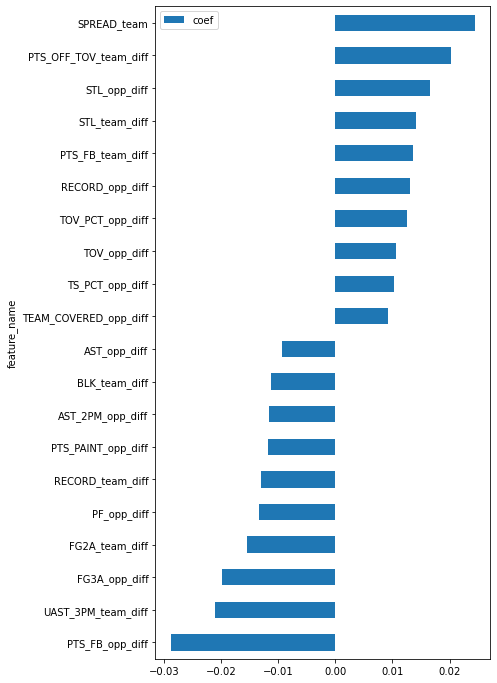

In [61]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                               max_iter=10000,
                                     random_state=23))])


print("best_sgd:", best_sgd)

best_sgd.fit(X_train, y_train)

print("train_score:", best_sgd.score(X_train, y_train))
print("test_score:", best_sgd.score(X_test, y_test))

view_model_coefs(best_sgd.named_steps['sgd'], X_train)

### LGBClassifier

In [62]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        num_leaves=num_leaves, 
                                        random_state=23,
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                       learning_rate=learning_rate)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=1, show_progress_bar=True)

[I 2021-10-29 12:05:15,424] Using an existing study with name 'study_lgbc' instead of creating a new one.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2021-10-29 12:05:17,554] Trial 800 finished with value: 0.5214823393167342 and parameters: {'min_child_weight': 0.6399613011203054, 'subsample': 0.6665191703040864, 'max_depth': 3, 'reg_lambda': 5.6496237199269075, 'reg_alpha': 2.3770052922007148, 'num_leaves': 58, 'colsample_bytree': 0.26918005855063437, 'learning_rate': 0.05517287791733717}. Best is trial 759 with value: 0.5284887087434859.


best_lgbc: LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508)
train_acc: 0.5904945717732207
test_acc: 0.5111786947229985
LGBoost or XGBoost


feature_name  coef
45             PF_opp_diff     1
86            elo_MOV_pred     1
5            FTM_team_diff     1
21           PIE_team_diff     1
7           OREB_team_diff     1
20          POSS_team_diff     1
63             WL_PCT_diff     1
10           AST_team_diff     1
73       REB_PCT_team_diff     2
77       EFG_PCT_team_diff     2
16    PLUS_MINUS_team_diff     2
34           FG3M_opp_diff     2
69      OREB_PCT_team_diff     3
74        REB_PCT_opp_diff     3
17  E_OFF_RATING_team_diff     3
26       AST_2PM_team_diff     3
51           POSS_opp_diff     3
55    PTS_OFF_TOV_opp_diff     3
83           team_elo_pred     3
8           DREB_team_diff     3
6            FTA_team_diff     3
66             AVG_ML_diff     3
44            TOV_opp_diff     3
31         RECORD_opp_diff     3
88                 ML_team     4
39           DREB_opp_diff     4
40            REB_opp_diff     4
81       TOV_PCT_team_diff     4
84           team_rating_i     4
25     PTS_PAINT_team_diff     4
64            ATS_PCT_diff     4
43            BLK_opp_diff     5
49   E_DEF_RATING_opp_diff     5
79     AST_RATIO_team_diff     5
1           FG2M_team_diff     5
67       AVG_ATS_DIFF_diff     5
27       AST_3PM_team_diff     6
36            FTM_opp_diff     6
46            PTS_opp_diff     6
52            PIE_opp_diff     6
13           TOV_team_diff     6
9            REB_team_diff     6
14            PF_team_diff     7
2           FG2A_team_diff     7
61       ATS_DIFF_opp_diff     8
58        AST_3PM_opp_diff     8
71      DREB_PCT_team_diff     8
0         RECORD_team_diff     8
41            AST_opp_diff     8
30      ATS_DIFF_team_diff     8
18  E_DEF_RATING_team_diff     8
48   E_OFF_RATING_opp_diff     9
33           FG2A_opp_diff     9
32           FG2M_opp_diff    10
12           BLK_team_diff    10
15           PTS_team_diff    10
70       OREB_PCT_opp_diff    11
3           FG3M_team_diff    11
59       UAST_2PM_opp_diff    11
82        TOV_PCT_opp_diff    12
78        EFG_PCT_opp_diff    12
60       UAST_3PM_opp_diff    13
87             SPREAD_team    13
37            FTA_opp_diff    13
23        PTS_FB_team_diff    13
57        AST_2PM_opp_diff    14
56      PTS_PAINT_opp_diff    14
38           OREB_opp_diff    14
28      UAST_2PM_team_diff    15
35           FG3A_opp_diff    17
29      UAST_3PM_team_diff    18
62   TEAM_COVERED_opp_diff    19
53     PTS_2PT_MR_opp_diff    19
42            STL_opp_diff    19
11           STL_team_diff    20
4           FG3A_team_diff    21
80      AST_RATIO_opp_diff    22
22    PTS_2PT_MR_team_diff    23
24   PTS_OFF_TOV_team_diff    26
76         TS_PCT_opp_diff    32
54         PTS_FB_opp_diff    39

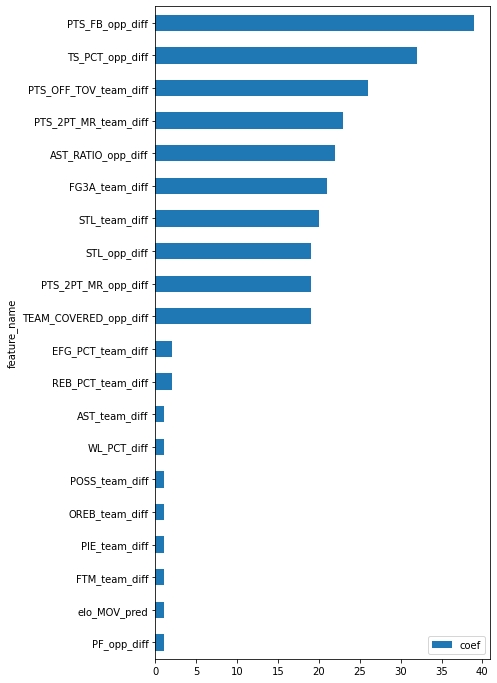

In [63]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [64]:
from sklearn.decomposition import PCA


### KNNeighbors

In [396]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    pca__n_components = trial.suggest_int('n_components', 5, 50)
    
    classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=pca__n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))]) 
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_knn3'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(23, 60, 2).tolist(),
               'n_components':np.arange(5, 20, 2).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-10-28 23:21:42,467] Using an existing study with name 'study_knn3' instead of creating a new one.
[I 2021-10-28 23:21:44,825] Trial 152 finished with value: 0.5019687319050377 and parameters: {'n_neighbors': 47, 'n_components': 11}. Best is trial 18 with value: 0.5114649681528662.
[I 2021-10-28 23:21:46,875] Trial 153 finished with value: 0.5009843659525188 and parameters: {'n_neighbors': 33, 'n_components': 11}. Best is trial 18 with value: 0.5114649681528662.
[I 2021-10-28 23:21:48,298] Trial 154 finished with value: 0.5011001737116387 and parameters: {'n_neighbors': 57, 'n_components': 7}. Best is trial 18 with value: 0.5114649681528662.
[I 2021-10-28 23:21:51,377] Trial 155 finished with value: 0.5065431383902721 and parameters: {'n_neighbors': 31, 'n_components': 15}. Best is trial 18 with value: 0.5114649681528662.
[I 2021-10-28 23:21:54,863] Trial 156 finished with value: 0.50833815865663 and parameters: {'n_neighbors': 47, 'n_components': 17}. Best is trial 18 with valu

[I 2021-10-28 23:23:22,665] Trial 194 finished with value: 0.5131441806601043 and parameters: {'n_neighbors': 41, 'n_components': 15}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:23:25,541] Trial 195 finished with value: 0.5088013896931095 and parameters: {'n_neighbors': 35, 'n_components': 15}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:23:26,598] Trial 196 finished with value: 0.5 and parameters: {'n_neighbors': 55, 'n_components': 5}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:23:27,762] Trial 197 finished with value: 0.5023740590619571 and parameters: {'n_neighbors': 57, 'n_components': 5}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:23:30,271] Trial 198 finished with value: 0.5014475969889982 and parameters: {'n_neighbors': 47, 'n_components': 13}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:23:32,546] Trial 199 finished with value: 0.5047481181239143 and parameters

[I 2021-10-28 23:24:56,998] Trial 236 finished with value: 0.49884192240880143 and parameters: {'n_neighbors': 35, 'n_components': 17}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:25:01,018] Trial 237 finished with value: 0.5069484655471916 and parameters: {'n_neighbors': 59, 'n_components': 17}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:25:02,147] Trial 238 finished with value: 0.4987840185292415 and parameters: {'n_neighbors': 49, 'n_components': 5}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:25:03,892] Trial 239 finished with value: 0.4963520555877244 and parameters: {'n_neighbors': 35, 'n_components': 9}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:25:05,589] Trial 240 finished with value: 0.49722061378112337 and parameters: {'n_neighbors': 43, 'n_components': 9}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:25:07,441] Trial 241 finished with value: 0.498957730167921

[I 2021-10-28 23:26:41,809] Trial 278 finished with value: 0.5030110017371163 and parameters: {'n_neighbors': 41, 'n_components': 17}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:26:43,896] Trial 279 finished with value: 0.5044006948465547 and parameters: {'n_neighbors': 37, 'n_components': 11}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:26:47,735] Trial 280 finished with value: 0.5044006948465547 and parameters: {'n_neighbors': 51, 'n_components': 19}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:26:50,997] Trial 281 finished with value: 0.5079907353792705 and parameters: {'n_neighbors': 53, 'n_components': 15}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:26:52,352] Trial 282 finished with value: 0.4931094383323682 and parameters: {'n_neighbors': 25, 'n_components': 7}. Best is trial 194 with value: 0.5131441806601043.
[I 2021-10-28 23:26:55,441] Trial 283 finished with value: 0.507643312101910

In [65]:
# best_n = study_knn.best_trial.params['n_neighbors']
# best_n_components = study_knn.best_trial.params['n_components']
# print("best_n_neighbors:", best_n, "best_n_components:", best_n_components)



best_knn = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('knn', KNeighborsClassifier(n_neighbors=41))])

print(best_knn)

best_knn.fit(X_train, y_train)
print(best_knn.score(X_train, y_train))
print(best_knn.score(X_test, y_test))

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('knn', KNeighborsClassifier(n_neighbors=41))])
0.5657901085645356
0.5089593950353444


### Random Forest

In [66]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_rf2'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=1)

[I 2021-10-29 12:05:38,707] Using an existing study with name 'study_rf2' instead of creating a new one.
[I 2021-10-29 12:05:47,376] Trial 710 finished with value: 0.517544875506659 and parameters: {'min_samples_split': 0.041086265761833135, 'max_depth': 12, 'min_samples_leaf': 0.020469655226760308}. Best is trial 612 with value: 0.5229878401852923.


In [67]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = RandomForestClassifier(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                random_state=23)

{'max_depth': 14, 'min_samples_leaf': 0.011132401847594018, 'min_samples_split': 0.028510554930813045}


In [68]:
best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

rf train_acc: 0.6232086851628468
rf test_acc: 0.5110964984382705


LGBoost or XGBoost


feature_name      coef
68               REST_diff  0.000425
75        TS_PCT_team_diff  0.003852
49   E_DEF_RATING_opp_diff  0.005136
34           FG3M_opp_diff  0.005230
40            REB_opp_diff  0.005407
74        REB_PCT_opp_diff  0.005585
16    PLUS_MINUS_team_diff  0.005736
77       EFG_PCT_team_diff  0.005860
73       REB_PCT_team_diff  0.006178
69      OREB_PCT_team_diff  0.006236
46            PTS_opp_diff  0.006281
17  E_OFF_RATING_team_diff  0.006306
20          POSS_team_diff  0.006344
88                 ML_team  0.006371
7           OREB_team_diff  0.006372
52            PIE_opp_diff  0.006692
71      DREB_PCT_team_diff  0.006724
72       DREB_PCT_opp_diff  0.007552
50   E_NET_RATING_opp_diff  0.007801
63             WL_PCT_diff  0.007898
8           DREB_team_diff  0.007915
6            FTA_team_diff  0.007922
0         RECORD_team_diff  0.007937
65         AVG_SPREAD_diff  0.008136
84           team_rating_i  0.008243
19  E_NET_RATING_team_diff  0.008268
21           PIE_team_diff  0.008301
87             SPREAD_team  0.008360
64            ATS_PCT_diff  0.008468
10           AST_team_diff  0.008524
51           POSS_opp_diff  0.008576
9            REB_team_diff  0.008587
13           TOV_team_diff  0.008730
55    PTS_OFF_TOV_opp_diff  0.008735
66             AVG_ML_diff  0.008778
70       OREB_PCT_opp_diff  0.008894
45             PF_opp_diff  0.008920
86            elo_MOV_pred  0.008942
14            PF_team_diff  0.009257
39           DREB_opp_diff  0.009259
58        AST_3PM_opp_diff  0.009449
83           team_elo_pred  0.009641
59       UAST_2PM_opp_diff  0.009669
31         RECORD_opp_diff  0.009825
79     AST_RATIO_team_diff  0.010085
61       ATS_DIFF_opp_diff  0.010094
67       AVG_ATS_DIFF_diff  0.010283
47     PLUS_MINUS_opp_diff  0.010295
5            FTM_team_diff  0.010297
43            BLK_opp_diff  0.010355
1           FG2M_team_diff  0.010401
32           FG2M_opp_diff  0.010833
33           FG2A_opp_diff  0.010950
85            opp_rating_i  0.011199
30      ATS_DIFF_team_diff  0.011289
3           FG3M_team_diff  0.011615
23        PTS_FB_team_diff  0.011811
37            FTA_opp_diff  0.011830
28      UAST_2PM_team_diff  0.011860
38           OREB_opp_diff  0.012266
18  E_DEF_RATING_team_diff  0.012306
26       AST_2PM_team_diff  0.012404
15           PTS_team_diff  0.012442
35           FG3A_opp_diff  0.012602
36            FTM_opp_diff  0.012627
81       TOV_PCT_team_diff  0.012740
62   TEAM_COVERED_opp_diff  0.012948
12           BLK_team_diff  0.013134
25     PTS_PAINT_team_diff  0.013181
44            TOV_opp_diff  0.013489
48   E_OFF_RATING_opp_diff  0.013833
60       UAST_3PM_opp_diff  0.014151
53     PTS_2PT_MR_opp_diff  0.014608
41            AST_opp_diff  0.014715
27       AST_3PM_team_diff  0.015631
82        TOV_PCT_opp_diff  0.015929
56      PTS_PAINT_opp_diff  0.016024
80      AST_RATIO_opp_diff  0.016958
29      UAST_3PM_team_diff  0.017332
42            STL_opp_diff  0.018701
24   PTS_OFF_TOV_team_diff  0.018880
2           FG2A_team_diff  0.019747
22    PTS_2PT_MR_team_diff  0.019883
78        EFG_PCT_opp_diff  0.020103
4           FG3A_team_diff  0.021010
11           STL_team_diff  0.021108
57        AST_2PM_opp_diff  0.023857
76         TS_PCT_opp_diff  0.024105
54         PTS_FB_opp_diff  0.042768

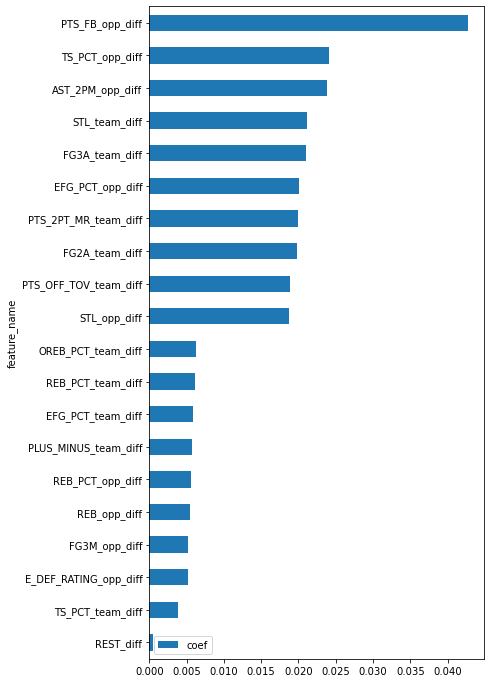

In [69]:
view_model_coefs(best_rf, X_train)

## Stacked Classifier

### new_version

stacked clf train_acc: 0.5603860072376357
stacked clf test_acc: 0.51565848030328
0
test set 1: 2016-10-27 - 2017-06-12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 168 epochs took 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


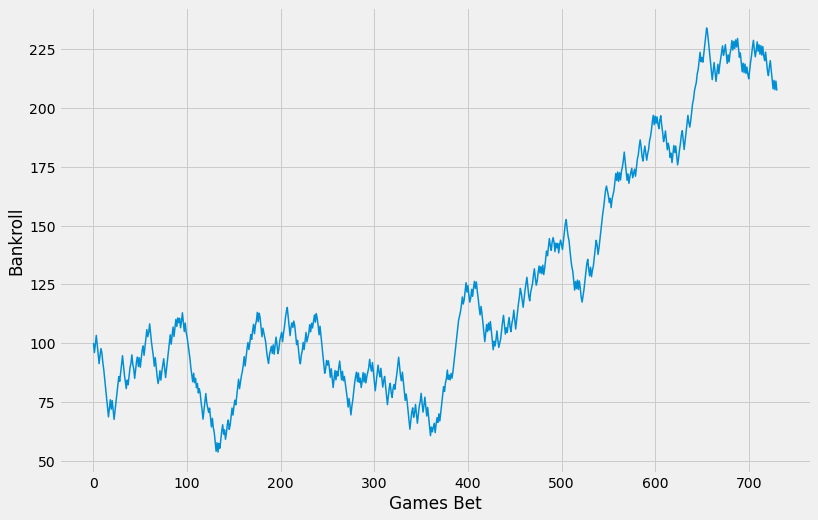

min balance: 53.63636363636379 
max balance: 234.09090909090878 
final balance: 209.27272727272663 
win percentage 54.86 
profit: 109.27272727272725 risk: 2489.0 
ROI: 4.390000000000001
1
test set 1: 2017-10-20 - 2018-06-08


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 178 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


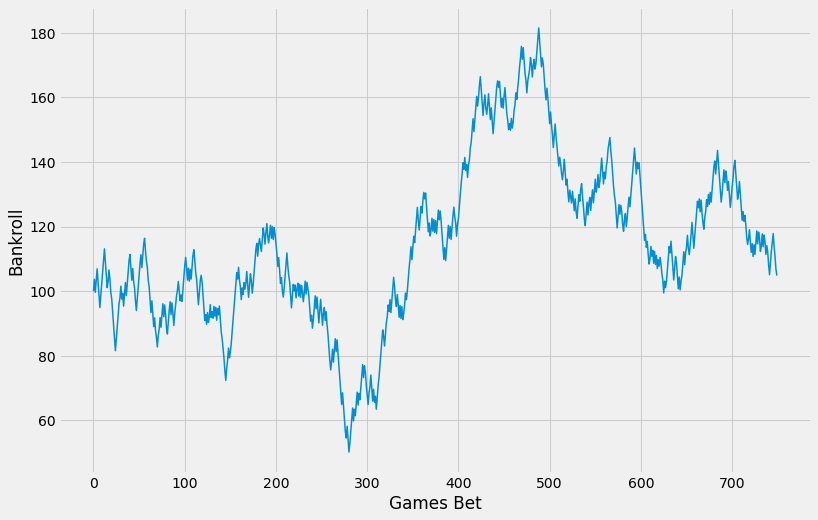

min balance: 50.181818181818564 
max balance: 181.45454545454558 
final balance: 101.81818181818161 
win percentage 51.6 
profit: 1.8181818181817562 risk: 2585.0 
ROI: 0.06999999999999999
2
test set 1: 2018-10-19 - 2019-06-13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 175 epochs took 7 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


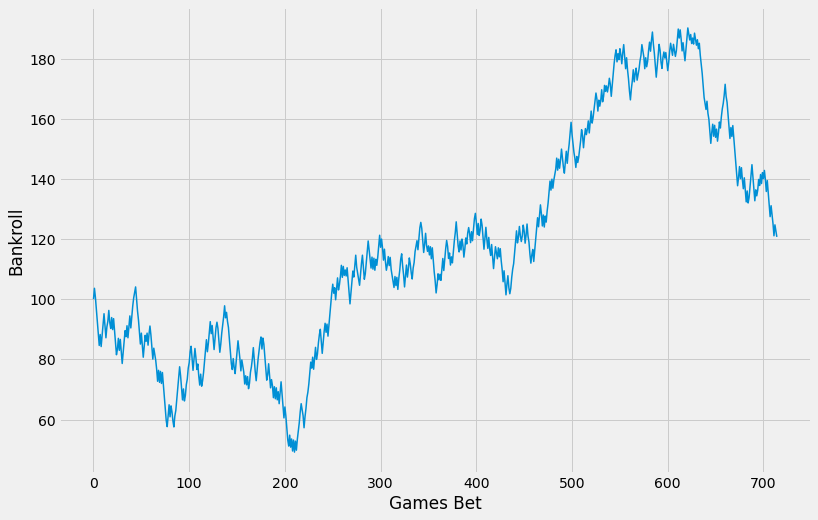

min balance: 49.181818181818436 
max balance: 190.18181818181807 
final balance: 117.72727272727231 
win percentage 51.74999999999999 
profit: 17.72727272727252 risk: 2403.0 
ROI: 0.74
3
test set 1: 2019-10-25 - 2020-10-11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 178 epochs took 8 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


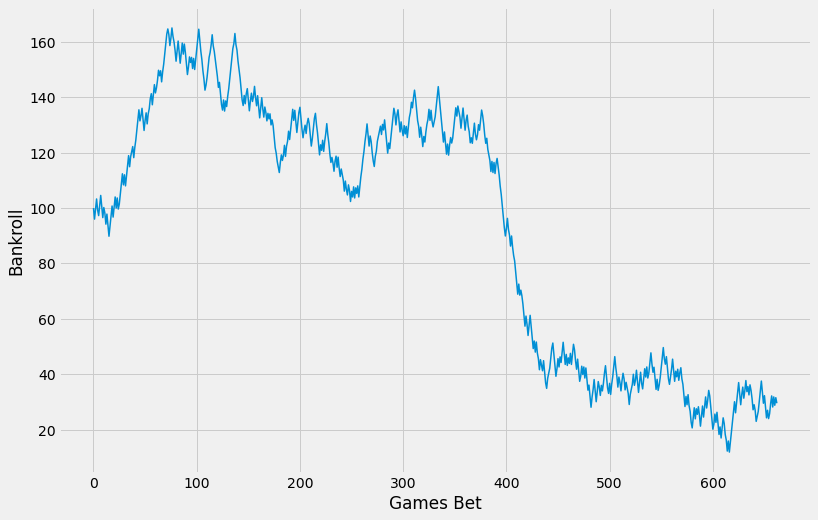

min balance: 11.909090909089919 
max balance: 164.99999999999986 
final balance: 33.181818181817164 
win percentage 49.919999999999995 
profit: -66.81818181818198 risk: 2268.0 
ROI: -2.9499999999999997
4
test set 1: 2020-12-25 - 2021-07-20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 185 epochs took 9 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


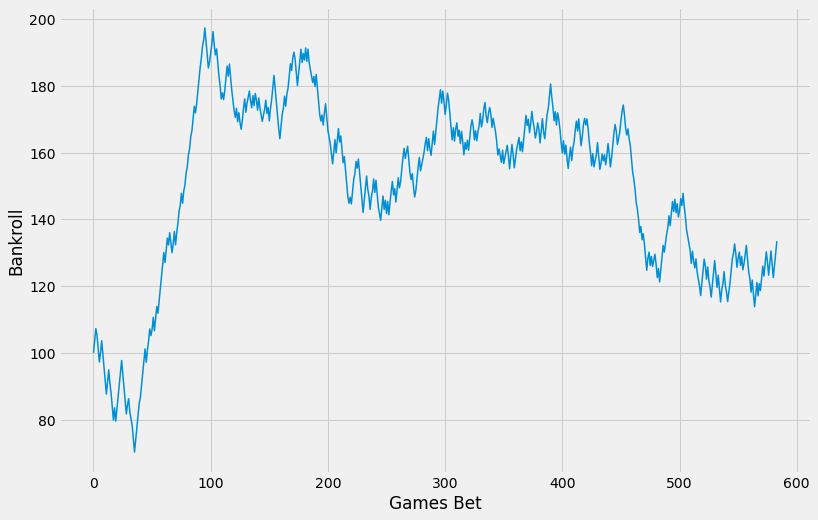

min balance: 70.27272727272732 
max balance: 197.36363636363623 
final balance: 137.09090909090725 
win percentage 53.25 
profit: 37.09090909090901 risk: 1935.0 
ROI: 1.92
5
test set 1: 2021-10-22 - 2021-10-26


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 164 epochs took 9 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished


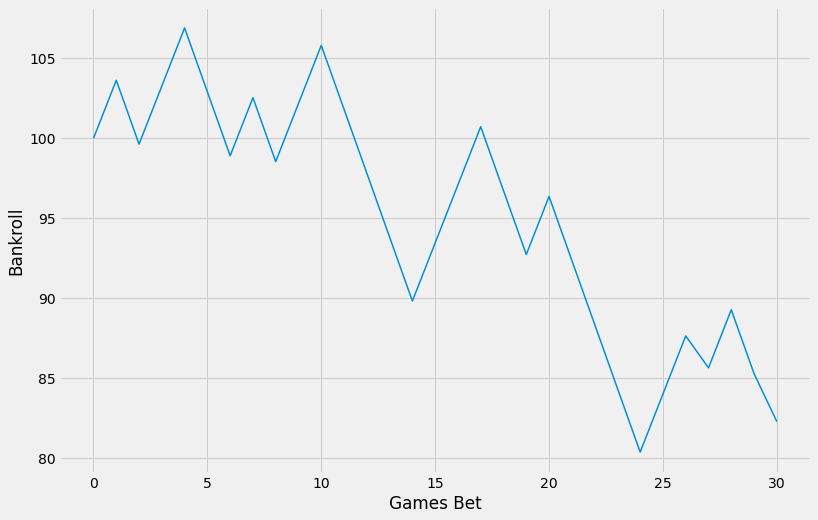

min balance: 78.27272727272732 
max balance: 106.90909090909092 
final balance: 78.27272727272732 
win percentage 41.94 
profit: -21.727272727272734 risk: 121.0 
ROI: -17.96

 Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.06226787404081285, max_iter=10000,
                                    random_state=23, solver='saga',
                                    verbose=1))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.548564            731  0.043902   
1  (2017, -, 2018)            0.53  0.516000            750  0.000703   
2  (2018, -, 2019)            0.53  0.517483            715  0.007377   
3  (2019, -, 2020)            0.53  0.499246            663 -0.029461   
4  (2020, -, 2021)            0.53  0.532534            584  0.019168   
5  (2021, -, 2021)            0.53  0.419355             31 -0.179564   

      profits  
0  109.272727  
1    1.818182 

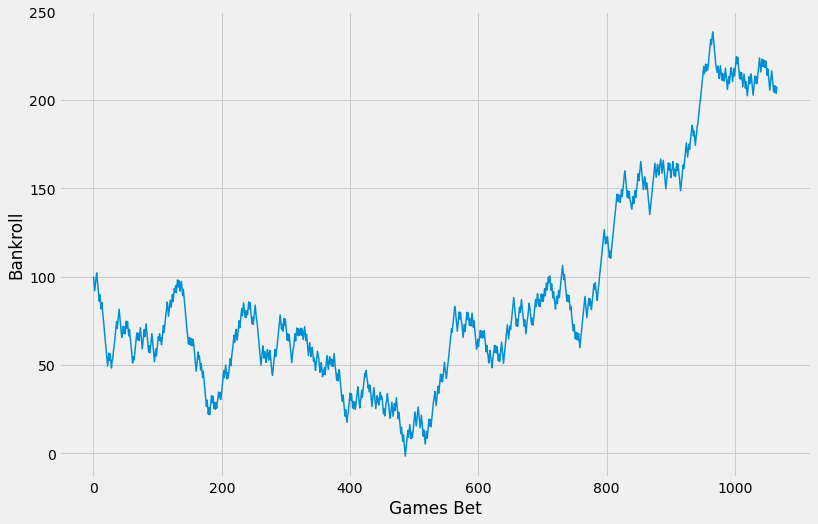

min balance: -1.7272727272726272 
max balance: 238.54545454545405 
final balance: 209.27272727272629 
win percentage 53.28000000000001 
profit: 109.27272727272702 risk: 4064.0 
ROI: 2.69
1
test set 1: 2017-10-20 - 2018-06-08


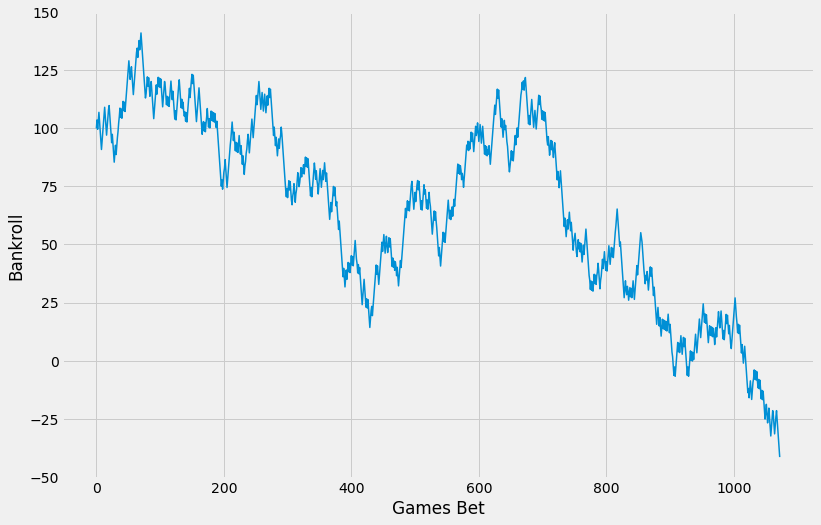

min balance: -45.54545454545388 
max balance: 141.09090909090915 
final balance: -45.54545454545388 
win percentage 50.7 
profit: -145.54545454545473 risk: 4126.0 
ROI: -3.53
2
test set 1: 2018-10-19 - 2019-06-13


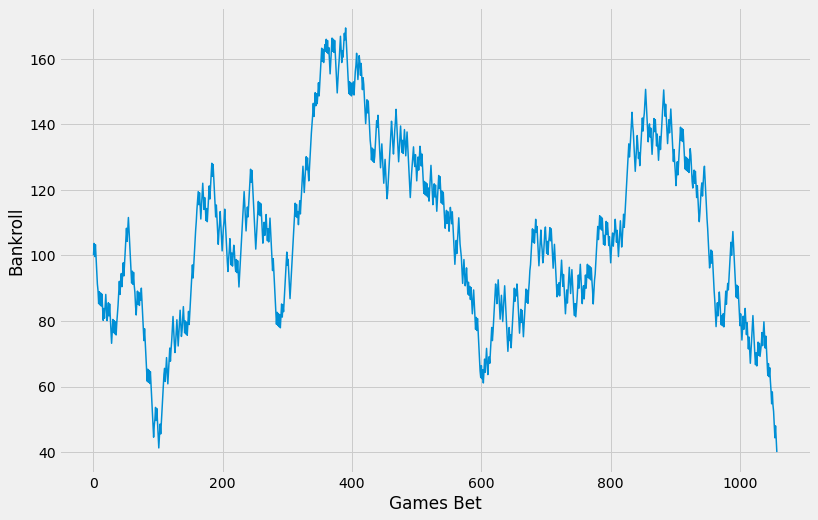

min balance: 36.0000000000001 
max balance: 169.36363636363663 
final balance: 36.0000000000001 
win percentage 51.7 
profit: -64.00000000000023 risk: 4033.0 
ROI: -1.59
3
test set 1: 2019-10-25 - 2020-10-11


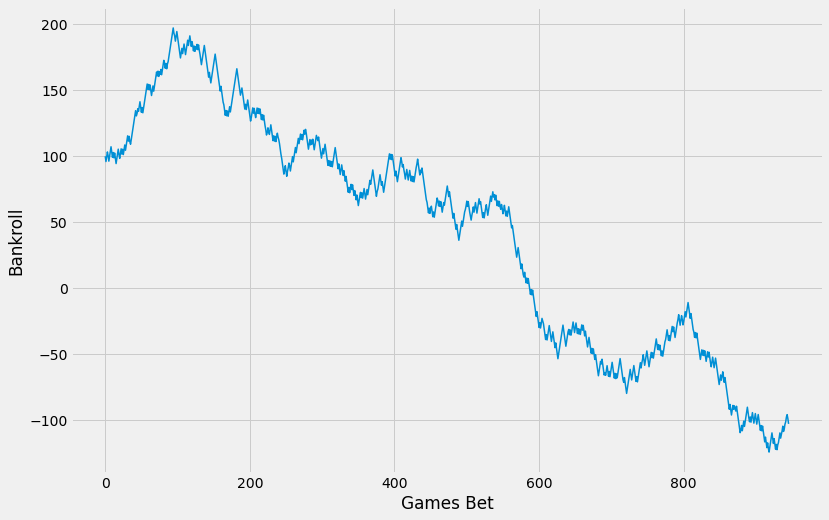

min balance: -124.09090909090963 
max balance: 197.1818181818179 
final balance: -99.09090909090959 
win percentage 49.26 
profit: -199.09090909090924 risk: 3645.0 
ROI: -5.46
4
test set 1: 2020-12-25 - 2021-07-20


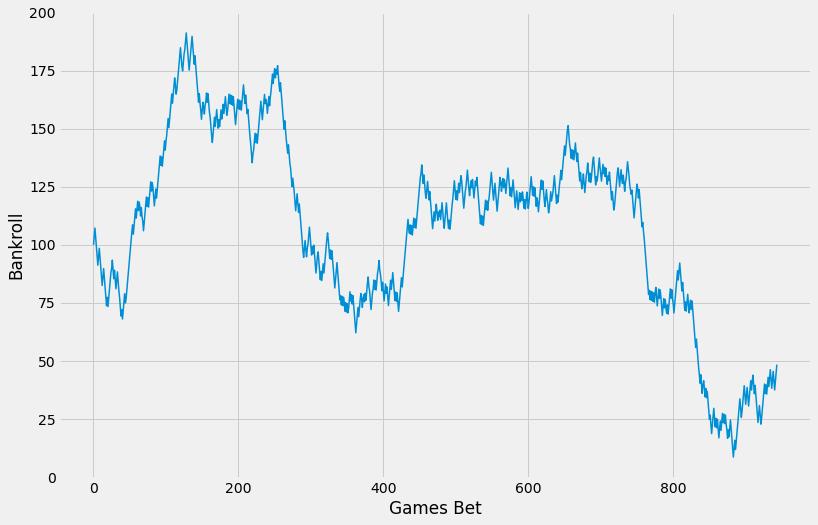

min balance: 8.636363636363168 
max balance: 191.27272727272717 
final balance: 52.090909090908546 
win percentage 51.480000000000004 
profit: -47.90909090909099 risk: 3574.0 
ROI: -1.34
5
test set 1: 2021-10-22 - 2021-10-26


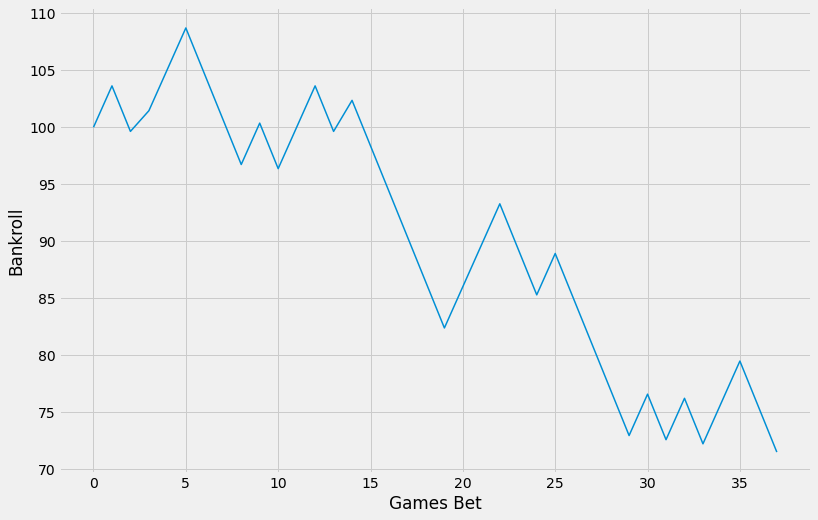

min balance: 67.45454545454551 
max balance: 108.72727272727273 
final balance: 67.45454545454551 
win percentage 42.11 
profit: -32.54545454545455 risk: 149.0 
ROI: -21.84

 Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.05305927223792528, loss='hinge', max_iter=100000,
                           random_state=23))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.532833           1066  0.026888   
1  (2017, -, 2018)            0.53  0.506990           1073 -0.035275   
2  (2018, -, 2019)            0.53  0.517013           1058 -0.015869   
3  (2019, -, 2020)            0.53  0.492600            946 -0.054620   
4  (2020, -, 2021)            0.53  0.514831            944 -0.013405   
5  (2021, -, 2021)            0.53  0.421053             38 -0.218426   

      profits  
0  109.272727  
1 -145.545455  
2  -64.000000  
3 -199.090909  
4  -47.909091  
5  -32.545455  
0
t

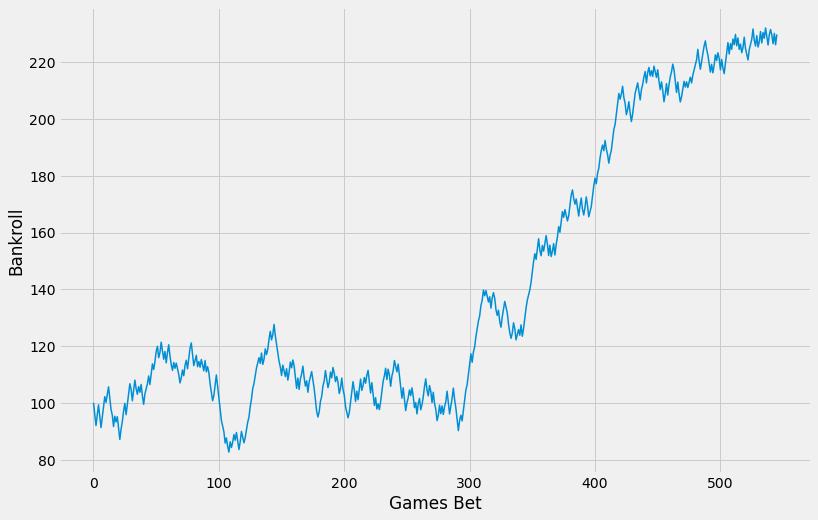

min balance: 82.63636363636374 
max balance: 232.09090909090835 
final balance: 225.81818181818105 
win percentage 55.489999999999995 
profit: 125.81818181818176 risk: 1684.0 
ROI: 7.470000000000001
1
test set 1: 2017-10-20 - 2018-06-08


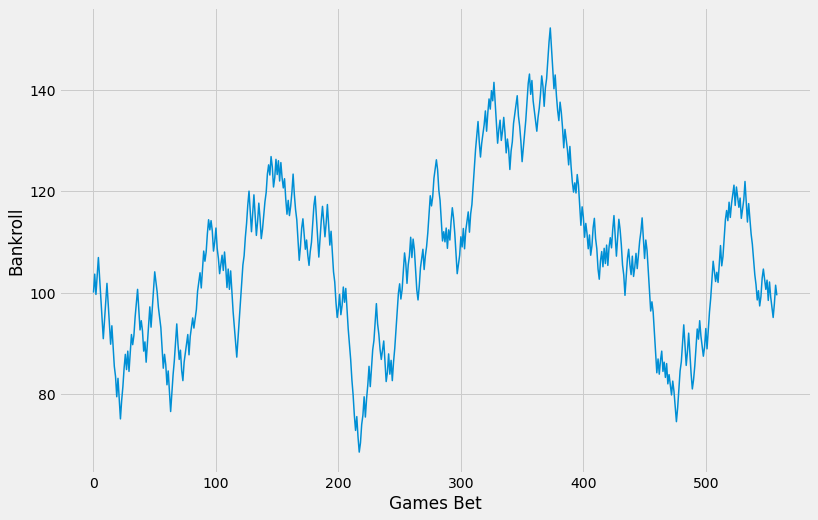

min balance: 68.54545454545476 
max balance: 152.1818181818182 
final balance: 97.45454545454554 
win percentage 52.59 
profit: -2.545454545454618 risk: 1778.0 
ROI: -0.13999999999999999
2
test set 1: 2018-10-19 - 2019-06-13


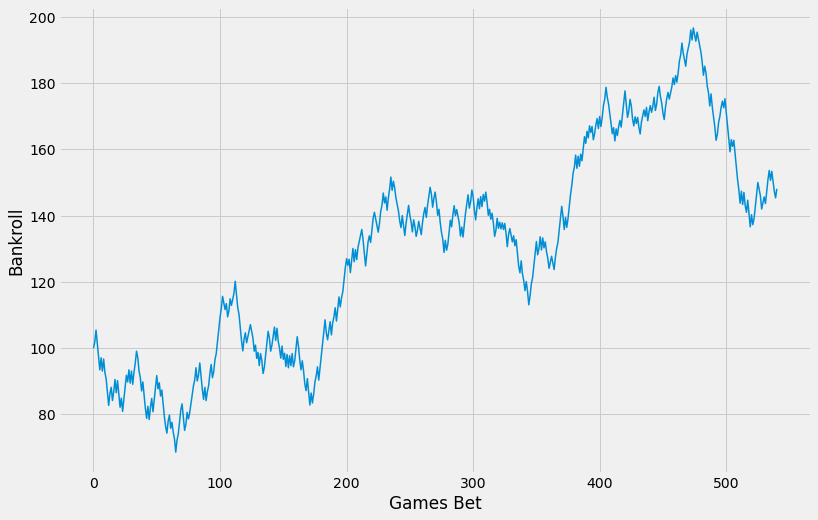

min balance: 68.63636363636371 
max balance: 196.63636363636277 
final balance: 149.90909090908983 
win percentage 53.42 
profit: 49.90909090909088 risk: 1695.0 
ROI: 2.94
3
test set 1: 2019-10-25 - 2020-10-11


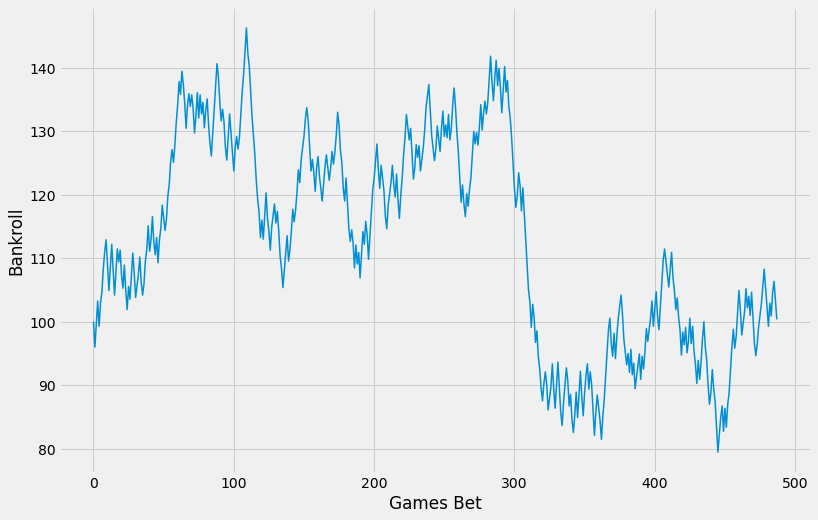

min balance: 79.45454545454524 
max balance: 146.2727272727271 
final balance: 103.99999999999982 
win percentage 52.05 
profit: 3.9999999999998863 risk: 1508.0 
ROI: 0.27
4
test set 1: 2020-12-25 - 2021-07-20


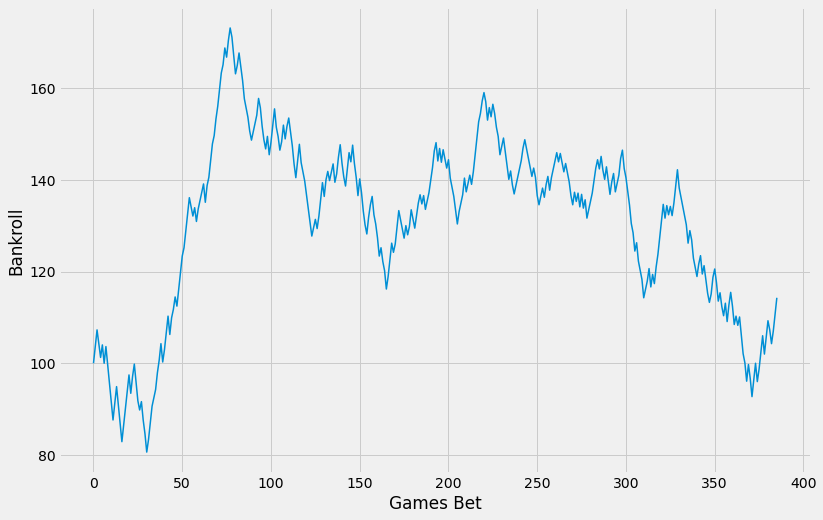

min balance: 80.63636363636368 
max balance: 173.090909090909 
final balance: 117.9090909090901 
win percentage 52.59 
profit: 17.909090909090878 risk: 1139.0 
ROI: 1.5699999999999998
5
test set 1: 2021-10-22 - 2021-10-26


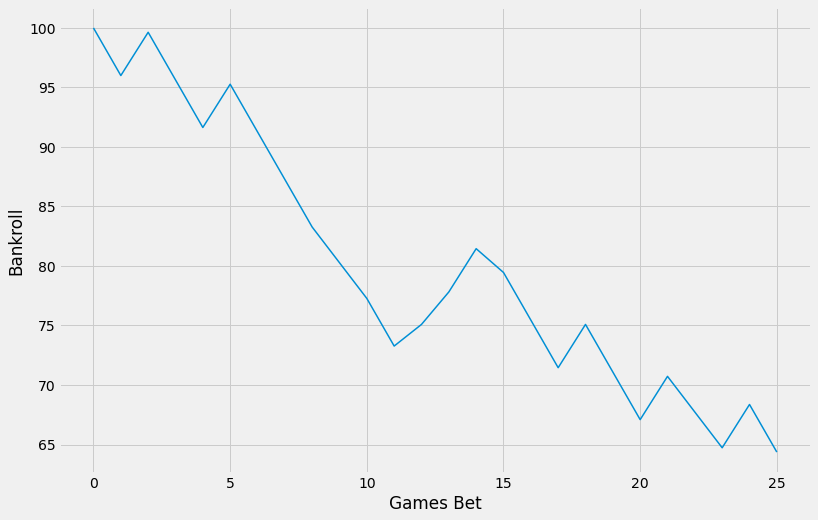

min balance: 60.36363636363639 
max balance: 99.63636363636364 
final balance: 60.36363636363639 
win percentage 30.769999999999996 
profit: -39.63636363636364 risk: 95.0 
ROI: -41.72

 Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.5629982879384883, loss='modified_huber',
                               max_iter=10000, random_state=23))])
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.554945            546  0.074714   
1  (2017, -, 2018)            0.53  0.525939            559 -0.001432   
2  (2018, -, 2019)            0.53  0.534196            541  0.029445   
3  (2019, -, 2020)            0.53  0.520492            488  0.002653   
4  (2020, -, 2021)            0.53  0.525907            386  0.015724   
5  (2021, -, 2021)            0.53  0.307692             26 -0.417225   

      profits  
0  125.818182  
1   -2.545455  
2   49.909091  
3    4.000000  
4   1

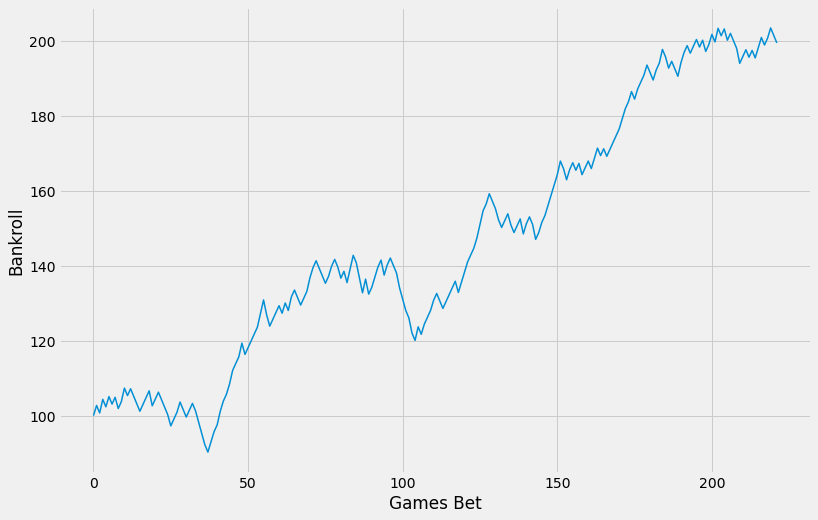

min balance: 90.27272727272724 
max balance: 203.54545454545388 
final balance: 201.3636363636357 
win percentage 60.809999999999995 
profit: 101.36363636363632 risk: 563.0 
ROI: 18.0
1
test set 1: 2017-10-20 - 2018-06-08


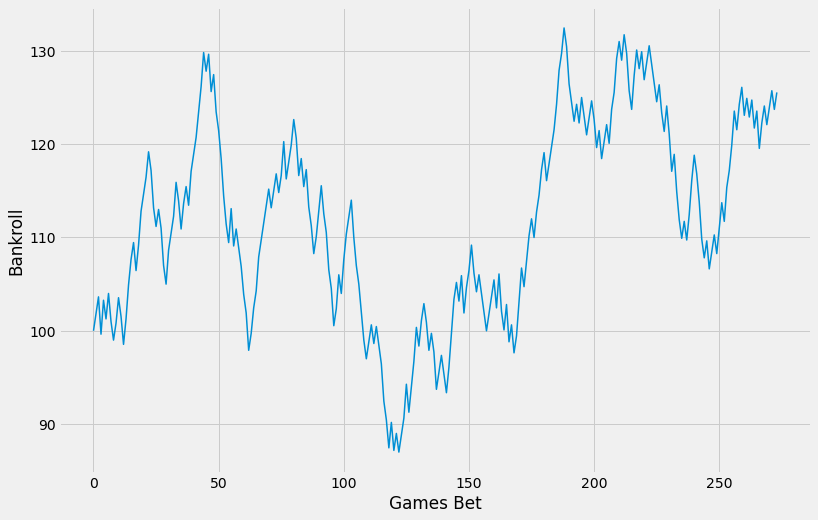

min balance: 86.99999999999996 
max balance: 132.4545454545454 
final balance: 123.54545454545443 
win percentage 54.379999999999995 
profit: 23.545454545454504 risk: 721.0 
ROI: 3.27
2
test set 1: 2018-10-19 - 2019-06-13


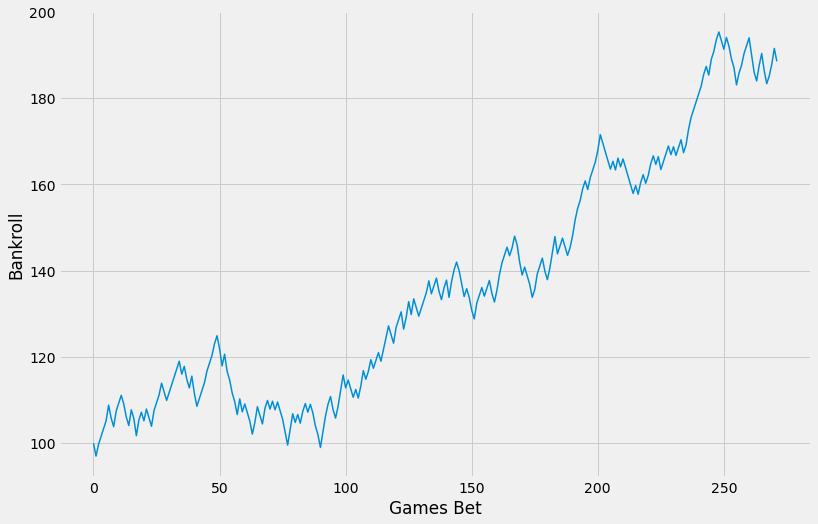

min balance: 97.0 
max balance: 195.36363636363583 
final balance: 185.54545454545394 
win percentage 57.35 
profit: 85.5454545454545 risk: 701.0 
ROI: 12.2
3
test set 1: 2019-10-25 - 2020-10-11


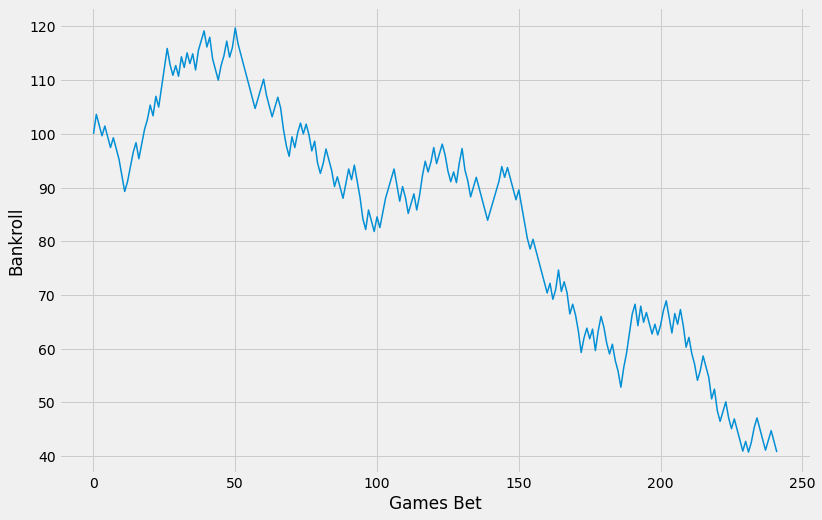

min balance: 40.727272727272705 
max balance: 119.72727272727275 
final balance: 42.54545454545453 
win percentage 46.28 
profit: -57.454545454545496 risk: 613.0 
ROI: -9.370000000000001
4
test set 1: 2020-12-25 - 2021-07-20


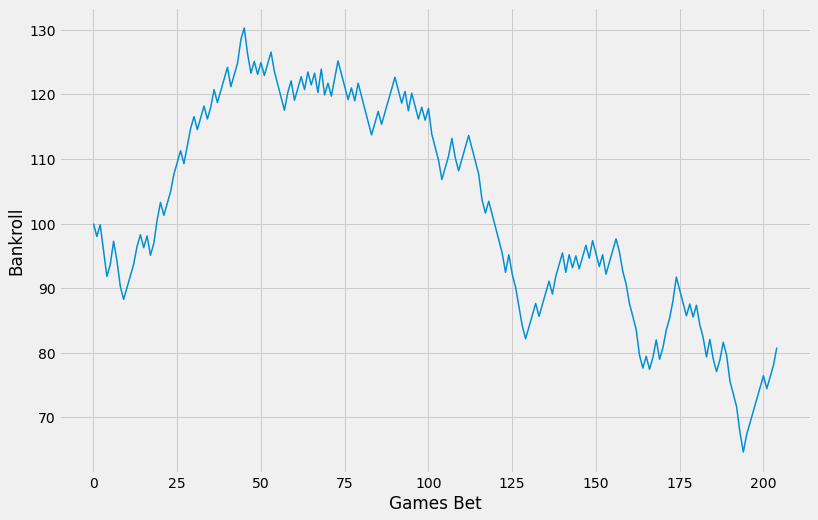

min balance: 64.63636363636343 
max balance: 130.2727272727272 
final balance: 82.6363636363634 
win percentage 51.71 
profit: -17.363636363636374 risk: 487.0 
ROI: -3.5700000000000003
5
test set 1: 2021-10-22 - 2021-10-26


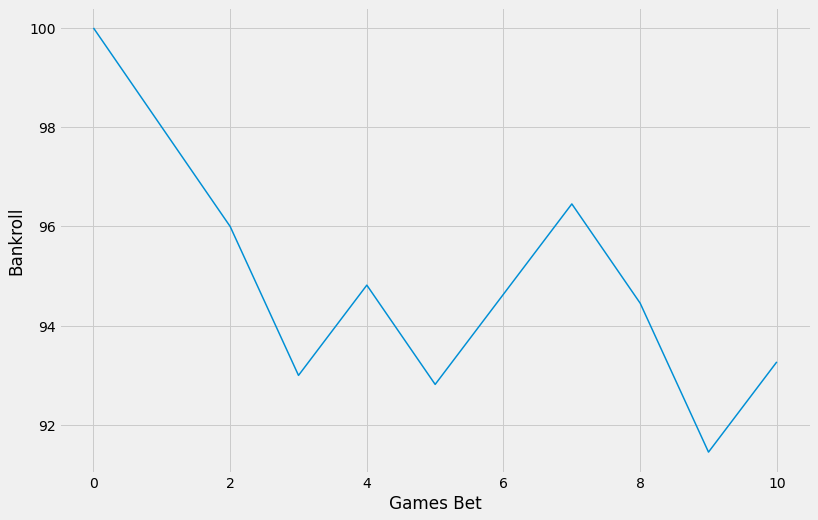

min balance: 91.45454545454544 
max balance: 98.0 
final balance: 95.09090909090907 
win percentage 45.45 
profit: -4.90909090909091 risk: 24.0 
ROI: -20.45

 RandomForestClassifier(max_depth=14, min_samples_leaf=0.011132401847594018,
                       min_samples_split=0.028510554930813045, random_state=23)
            season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.608108            222  0.180042   
1  (2017, -, 2018)            0.53  0.543796            274  0.032657   
2  (2018, -, 2019)            0.53  0.573529            272  0.122033   
3  (2019, -, 2020)            0.53  0.462810            242 -0.093727   
4  (2020, -, 2021)            0.53  0.517073            205 -0.035654   
5  (2021, -, 2021)            0.53  0.454545             11 -0.204545   

      profits  
0  101.363636  
1   23.545455  
2   85.545455  
3  -57.454545  
4  -17.363636  
5   -4.909091  
0
test set 1: 2016-10-27 - 2017-06-12


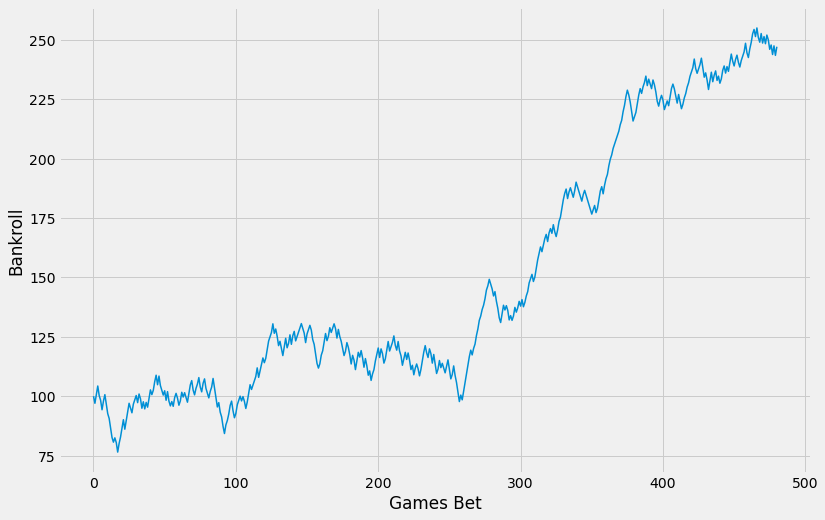

min balance: 76.45454545454547 
max balance: 254.99999999999923 
final balance: 243.09090909090827 
win percentage 57.379999999999995 
profit: 143.090909090909 risk: 1430.0 
ROI: 10.01
1
test set 1: 2017-10-20 - 2018-06-08


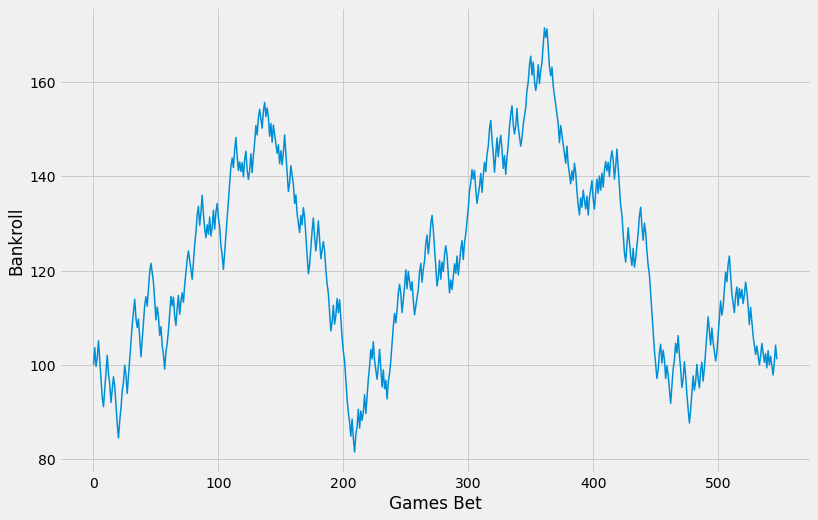

min balance: 81.45454545454524 
max balance: 171.5454545454541 
final balance: 98.18181818181762 
win percentage 51.28 
profit: -1.8181818181818699 risk: 1699.0 
ROI: -0.11
2
test set 1: 2018-10-19 - 2019-06-13


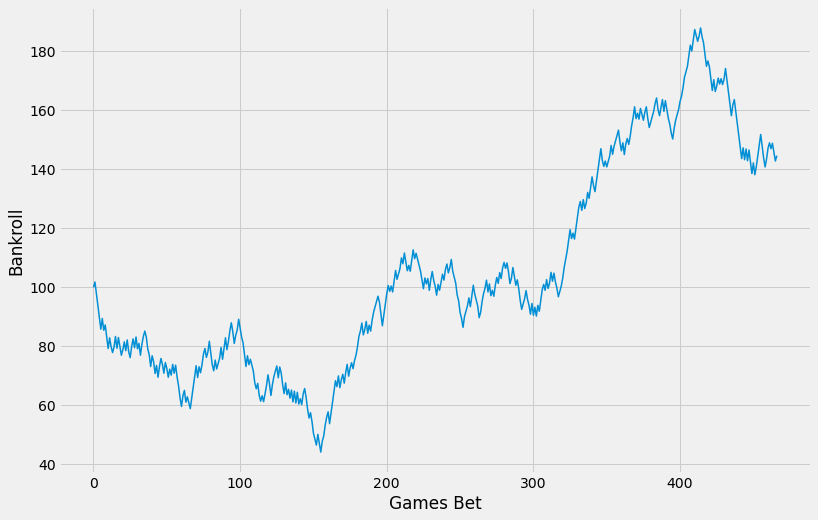

min balance: 44.1818181818183 
max balance: 187.90909090909076 
final balance: 142.6363636363633 
win percentage 53.53 
profit: 42.636363636363626 risk: 1435.0 
ROI: 2.97
3
test set 1: 2019-10-25 - 2020-10-11


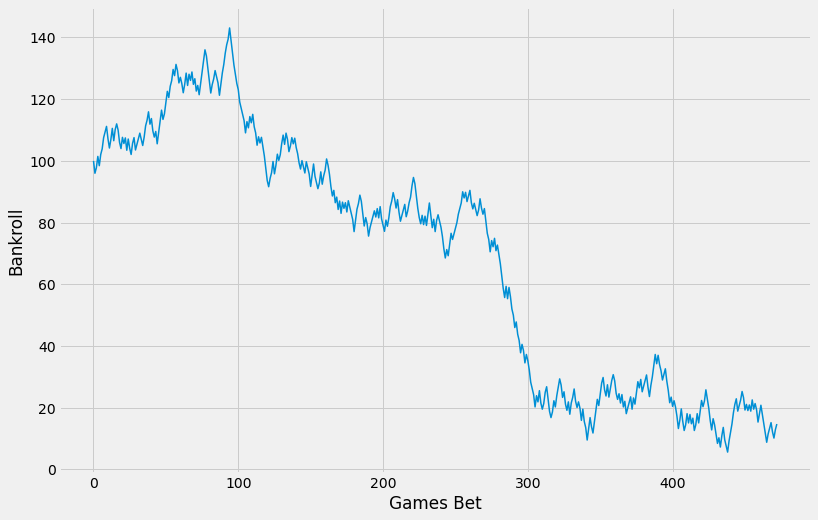

min balance: 5.636363636363596 
max balance: 143.090909090909 
final balance: 17.4545454545454 
win percentage 49.26 
profit: -82.54545454545462 risk: 1417.0 
ROI: -5.83
4
test set 1: 2020-12-25 - 2021-07-20


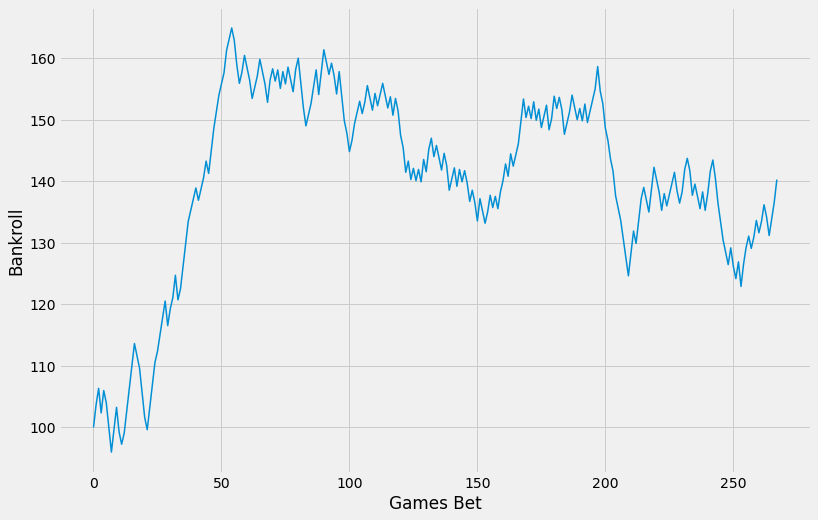

min balance: 96.00000000000001 
max balance: 164.90909090909085 
final balance: 142.99999999999923 
win percentage 53.73 
profit: 42.99999999999994 risk: 734.0 
ROI: 5.86
5
test set 1: 2021-10-22 - 2021-10-26


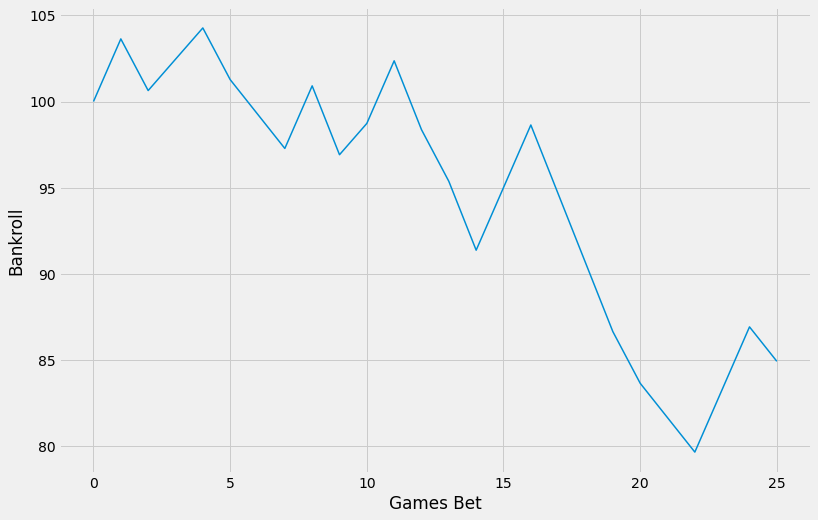

min balance: 79.63636363636364 
max balance: 104.27272727272727 
final balance: 80.90909090909092 
win percentage 38.46 
profit: -19.090909090909093 risk: 84.0 
ROI: -22.73

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.573805            481  0.100064   
1  (2017, -, 2018)            0.53  0.512774            548 -0.001070   
2  (2018, -, 2019)            0.53  0.535332            467  0.029712   
3  (2019, -, 2020)            0.53  0.492600            473 -0.058254   
4  (2020, -, 2021)            0.53  0.537313            268  0.058583   
5  (2021, -, 2021)            0.53  0.384615             26 -0.227273   

      profits  
0  143.090909  
1   -1.818182  
2   42.636364  
3  -82.545455  
4   43.000000  
5  -19.090909

In [412]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_svc, best_sgd, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

stacked clf train_acc: 0.5640048250904705
stacked clf test_acc: 0.512938849513763
0
test set 1: 2016-10-27 - 2017-06-12


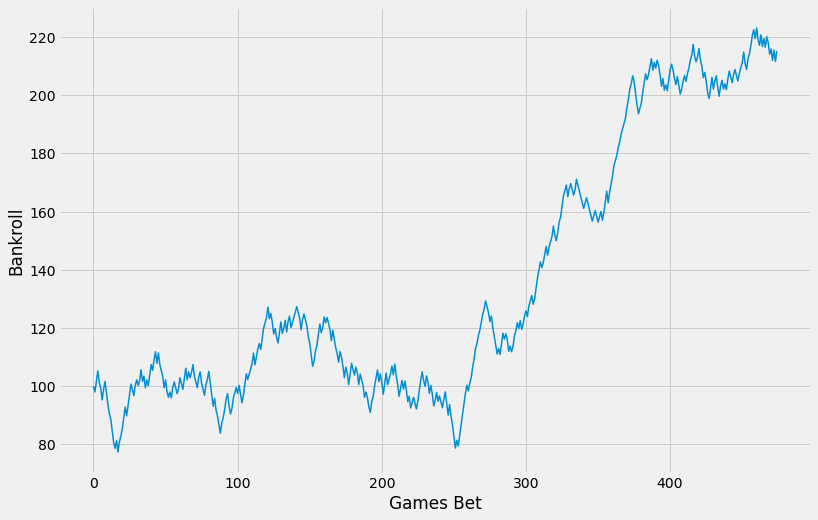

min balance: 77.36363636363639 
max balance: 223.0909090909086 
final balance: 211.18181818181765 
win percentage 55.78999999999999 
profit: 111.18181818181813 risk: 1397.0 
ROI: 7.960000000000001
1
test set 1: 2017-10-20 - 2018-06-08


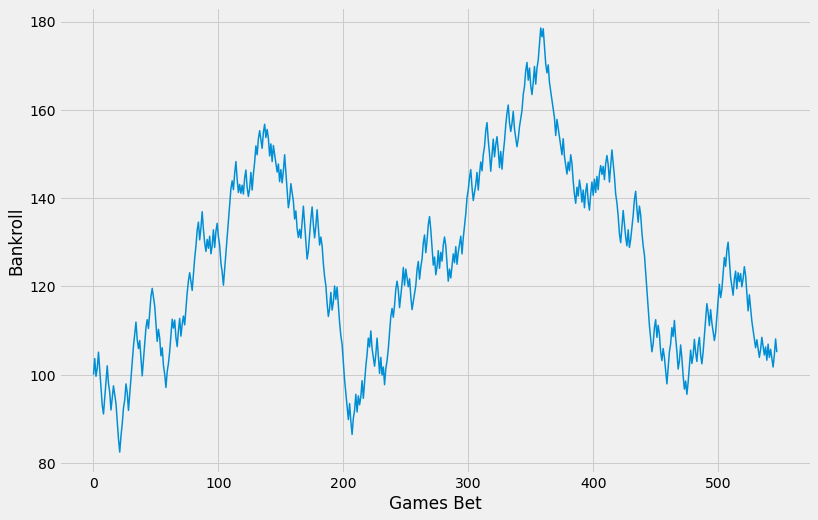

min balance: 82.45454545454548 
max balance: 178.54545454545396 
final balance: 102.0909090909083 
win percentage 51.28 
profit: 2.0909090909090082 risk: 1697.0 
ROI: 0.12
2
test set 1: 2018-10-19 - 2019-06-13


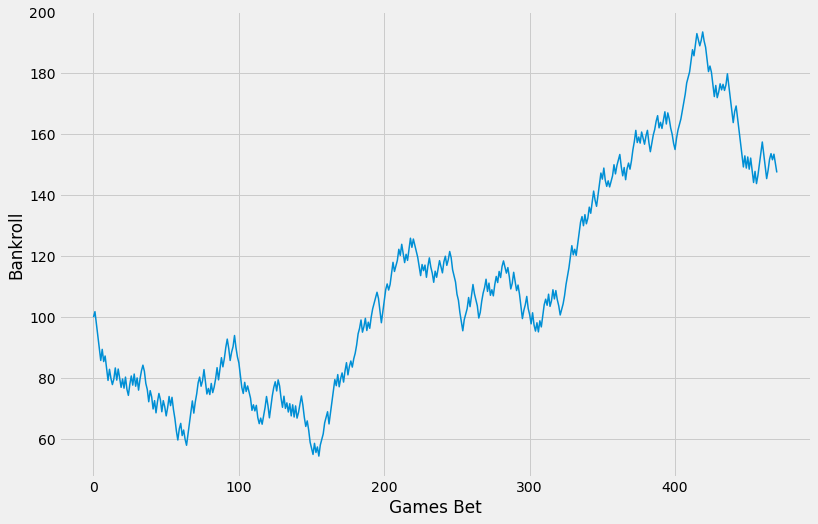

min balance: 54.45454545454561 
max balance: 193.54545454545445 
final balance: 149.272727272727 
win percentage 53.72 
profit: 49.27272727272725 risk: 1457.0 
ROI: 3.38
3
test set 1: 2019-10-25 - 2020-10-11


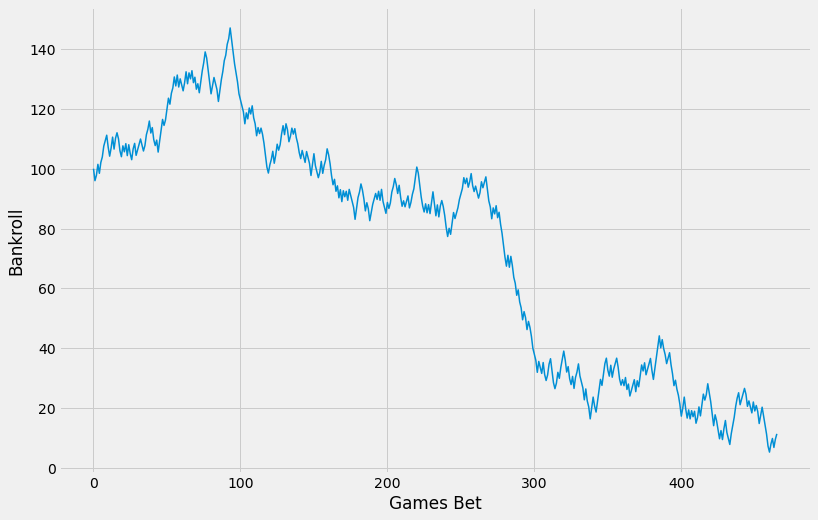

min balance: 5.363636363636289 
max balance: 146.99999999999986 
final balance: 14.181818181818105 
win percentage 48.93 
profit: -85.81818181818187 risk: 1405.0 
ROI: -6.11
4
test set 1: 2020-12-25 - 2021-07-20


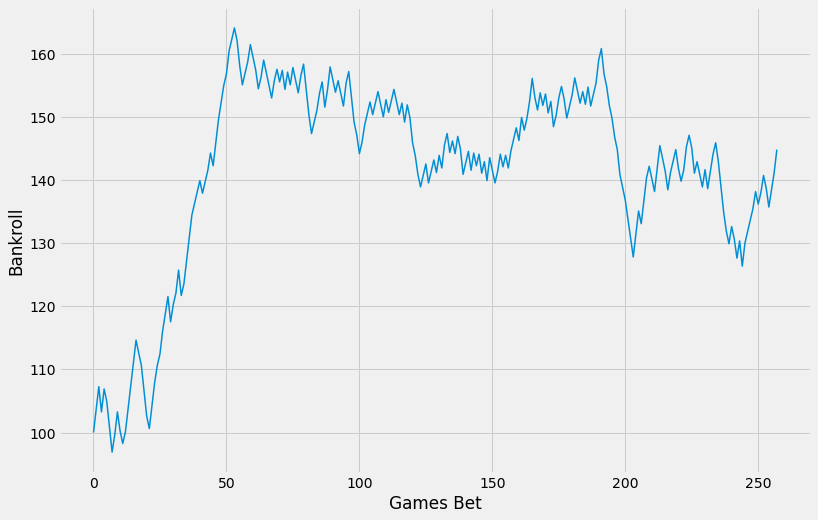

min balance: 96.90909090909092 
max balance: 164.09090909090904 
final balance: 147.5454545454538 
win percentage 54.65 
profit: 47.545454545454504 risk: 697.0 
ROI: 6.819999999999999
5
test set 1: 2021-10-22 - 2021-10-26


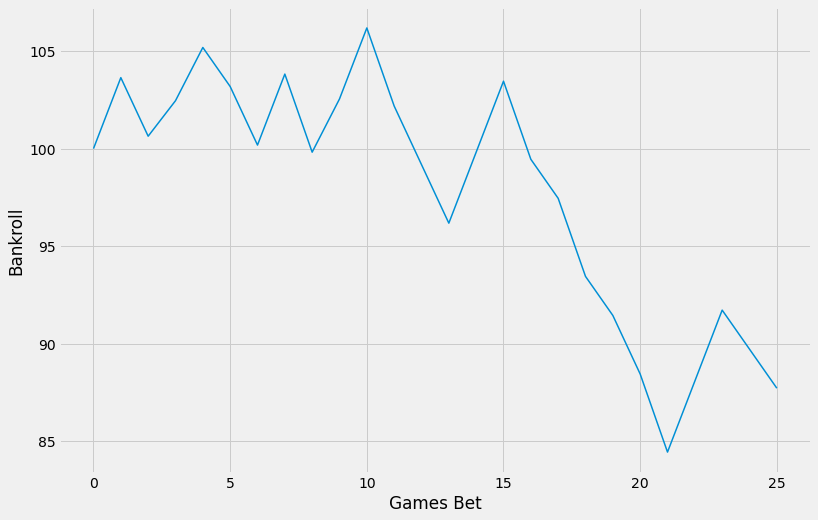

min balance: 83.72727272727276 
max balance: 106.1818181818182 
final balance: 83.72727272727276 
win percentage 38.46 
profit: -16.272727272727273 risk: 85.0 
ROI: -19.139999999999997

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=100000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                    

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.557895            475  0.079586   
1  (2017, -, 2018)            0.53  0.512774            548  0.001232   
2  (2018, -, 2019)            0.53  0.537155            471  0.033818   
3  (2019, -, 2020)            0.53  0.489270            466 -0.061081   
4  (2020, -, 2021)            0.53  0.546512            258  0.068214   
5  (2021, -, 2021)            0.53  0.384615             26 -0.191444   

      profits  
0  111.181818  
1    2.090909  
2   49.272727  
3  -85.818182  
4   47.545455  
5  -16.272727

In [414]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


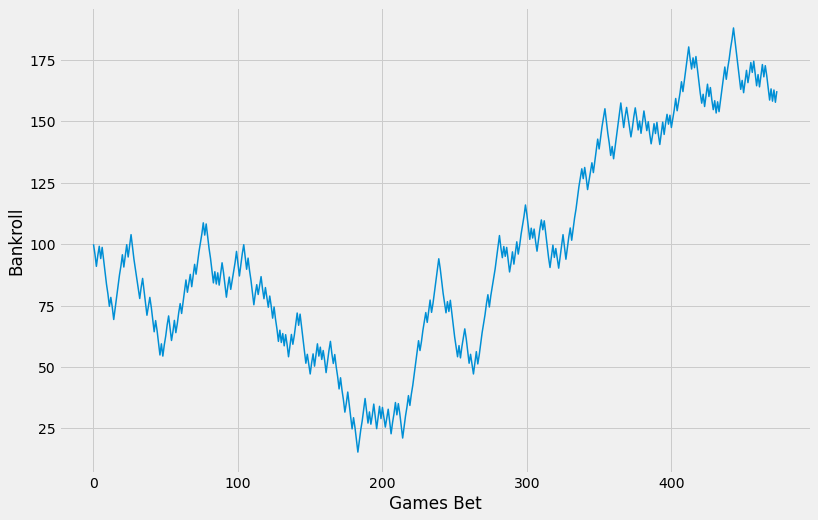

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


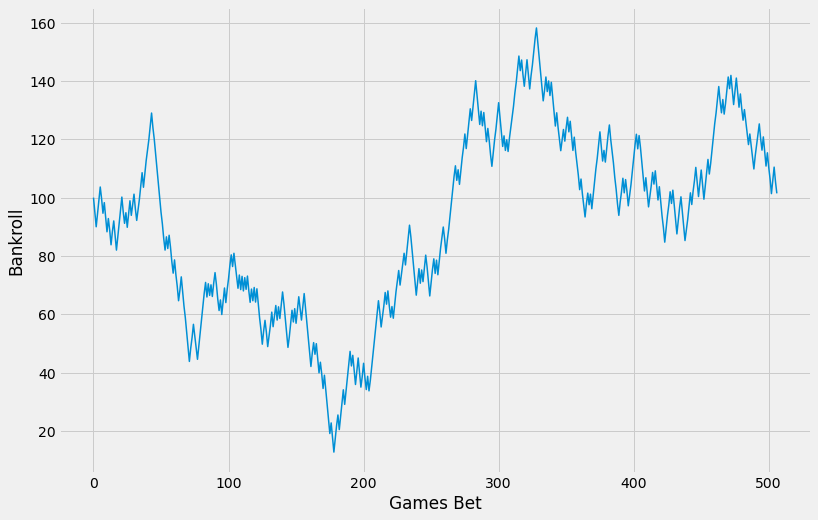

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


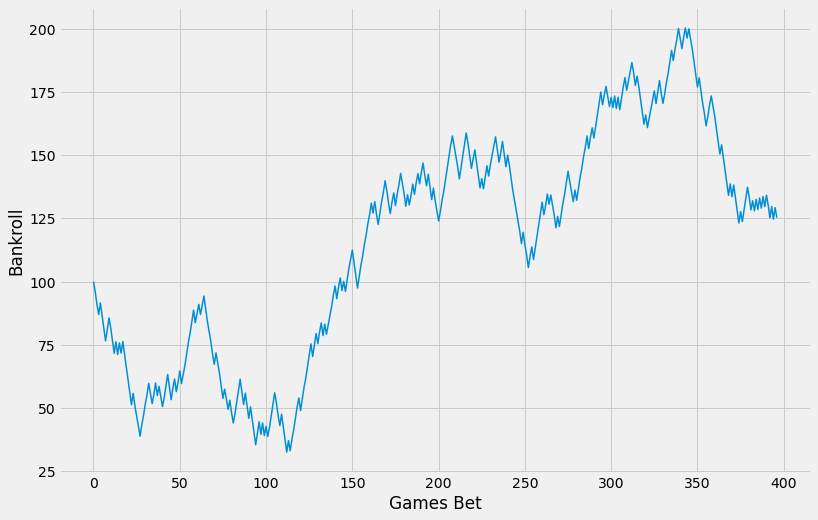

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


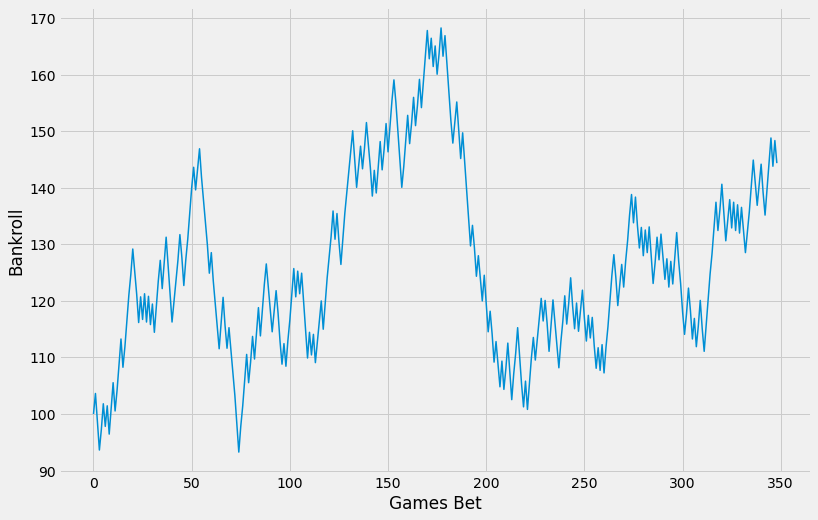

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


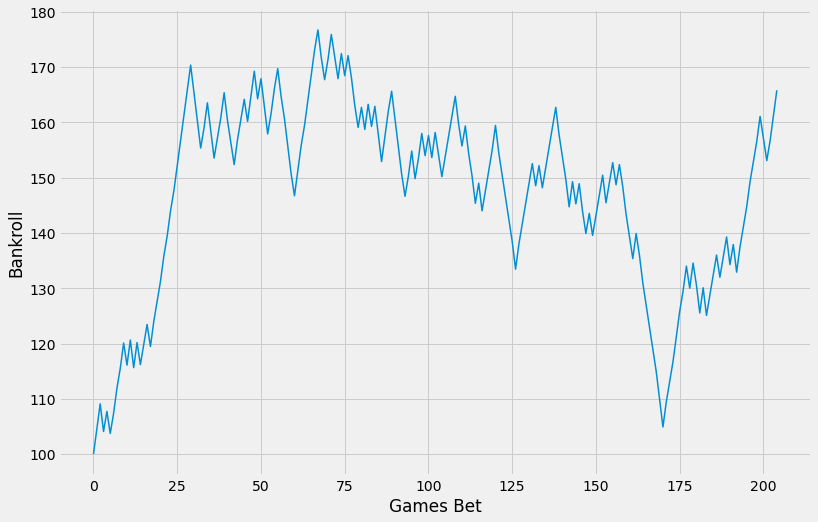

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


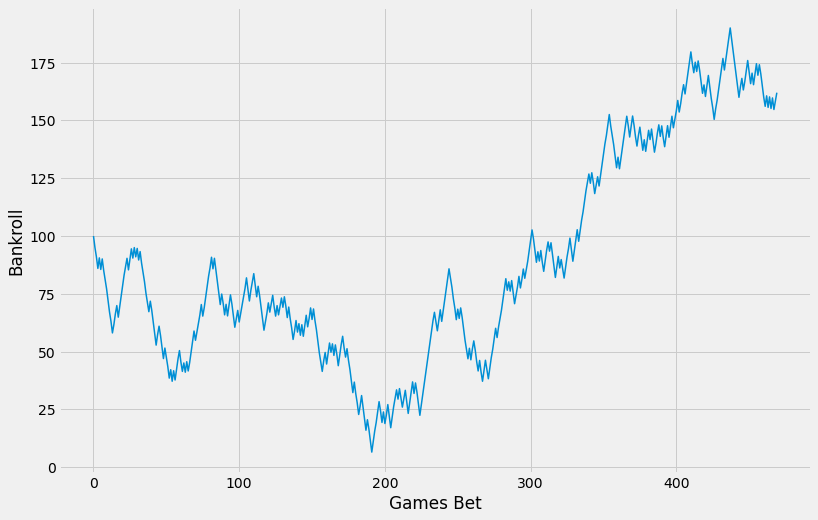

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


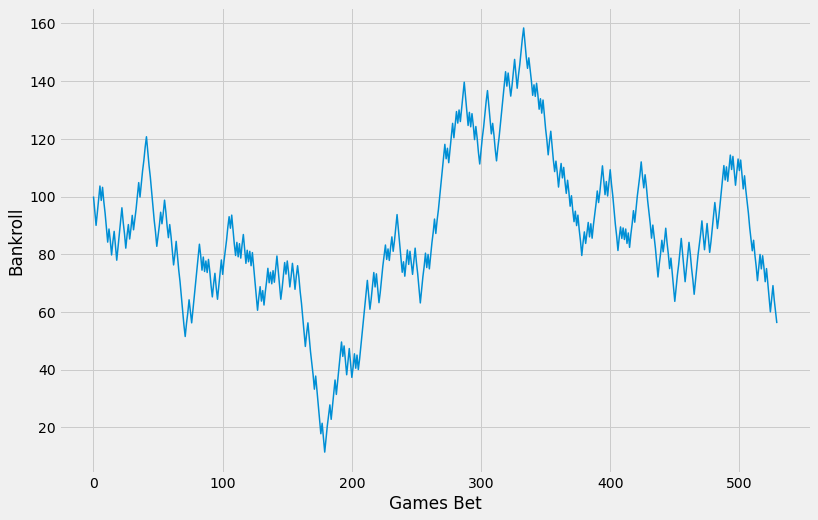

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


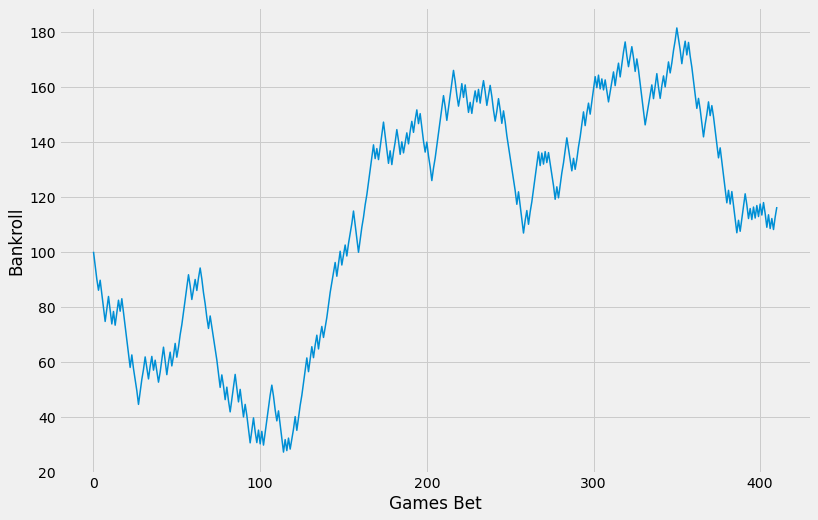

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


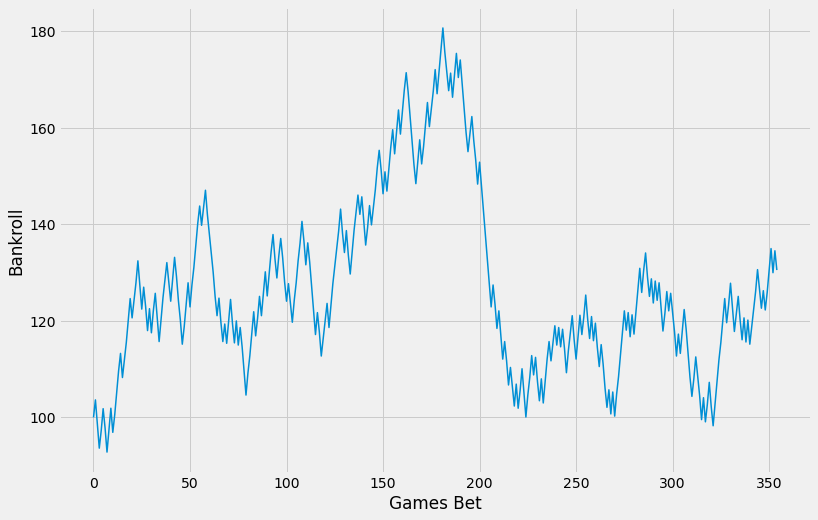

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


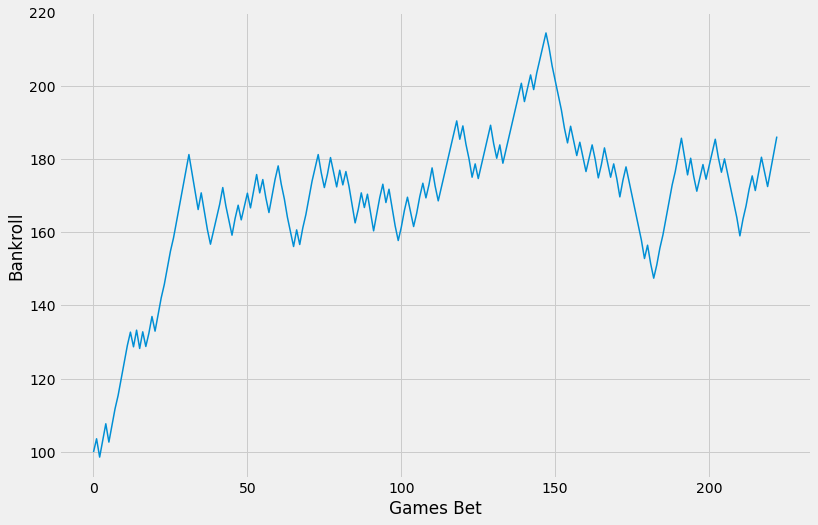

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


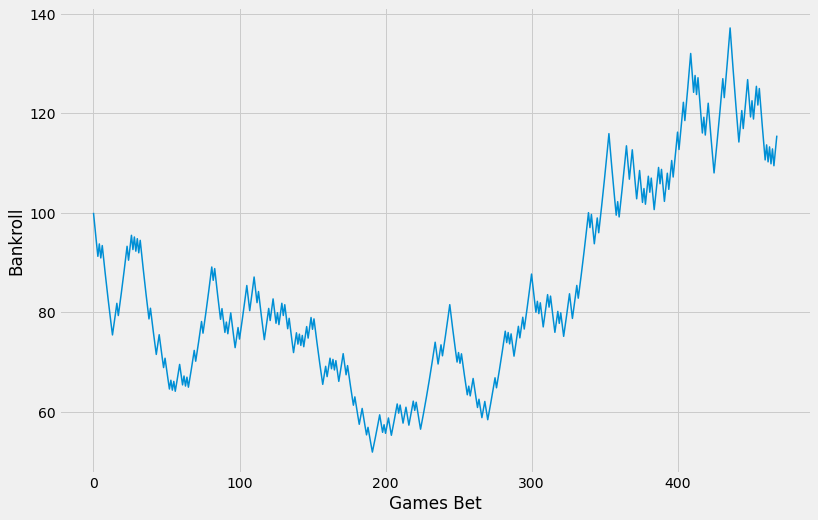

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


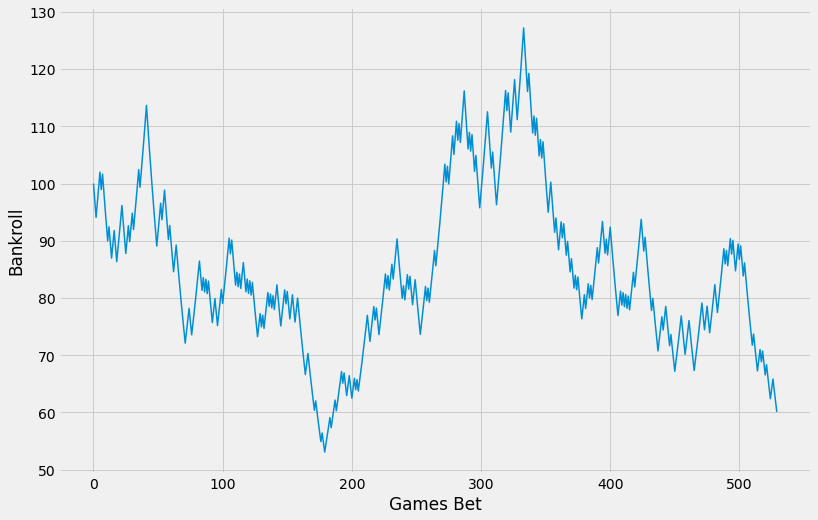

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


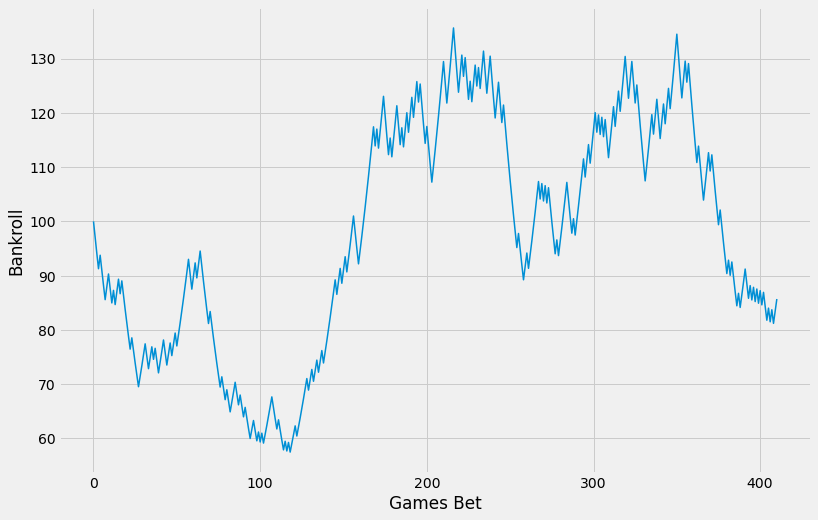

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


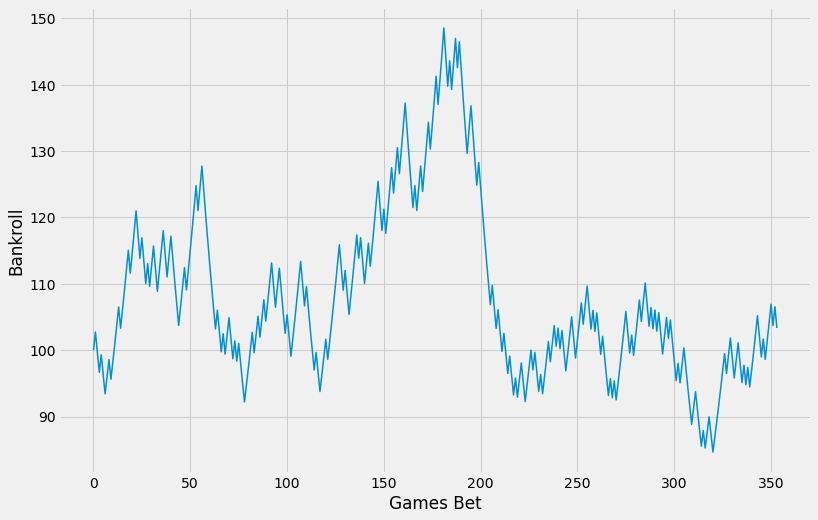

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


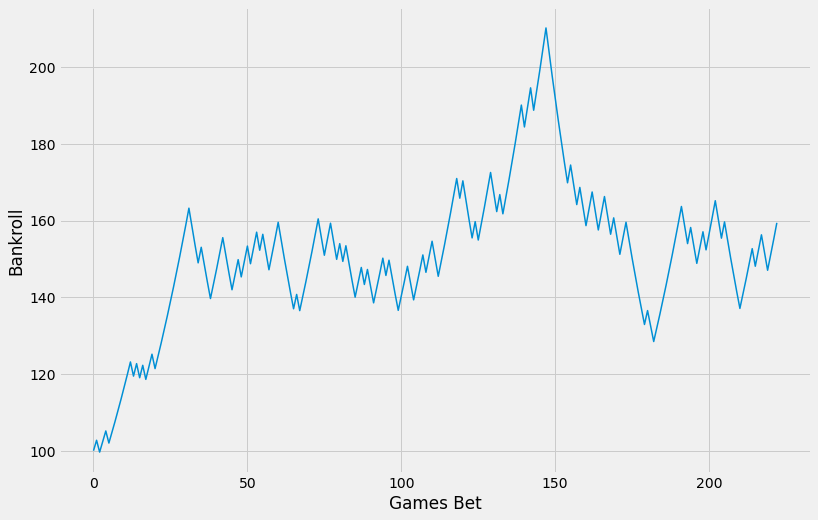

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


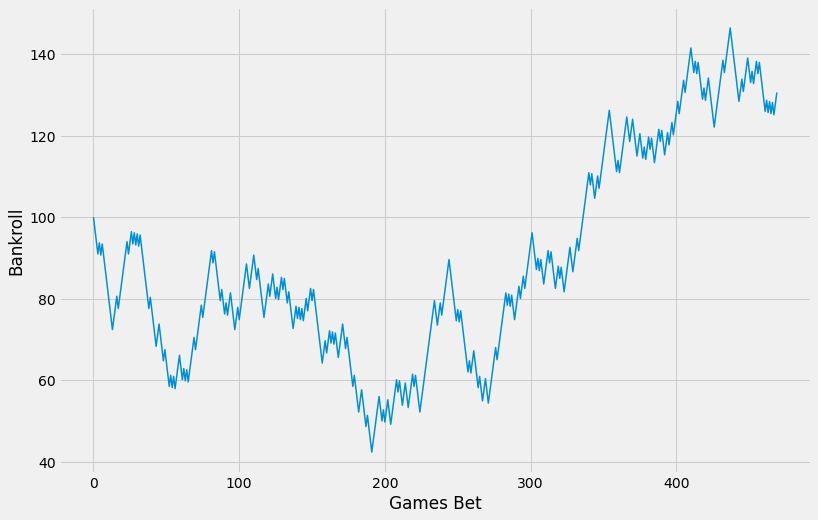

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


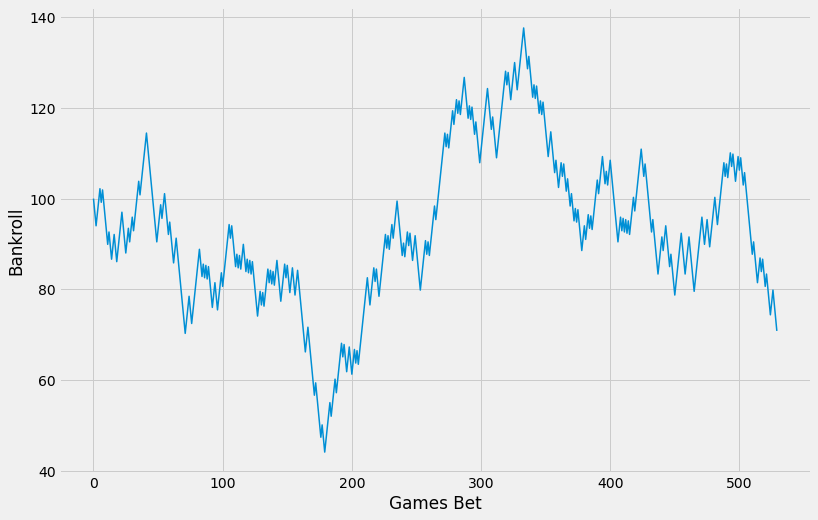

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


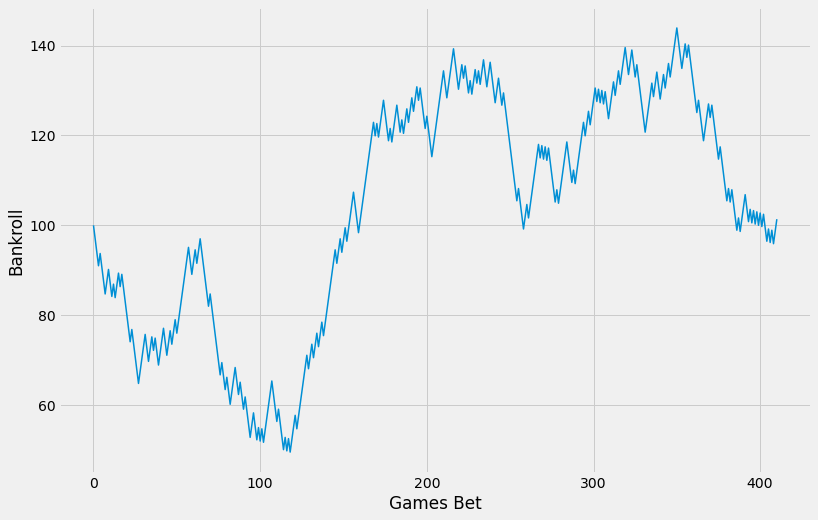

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


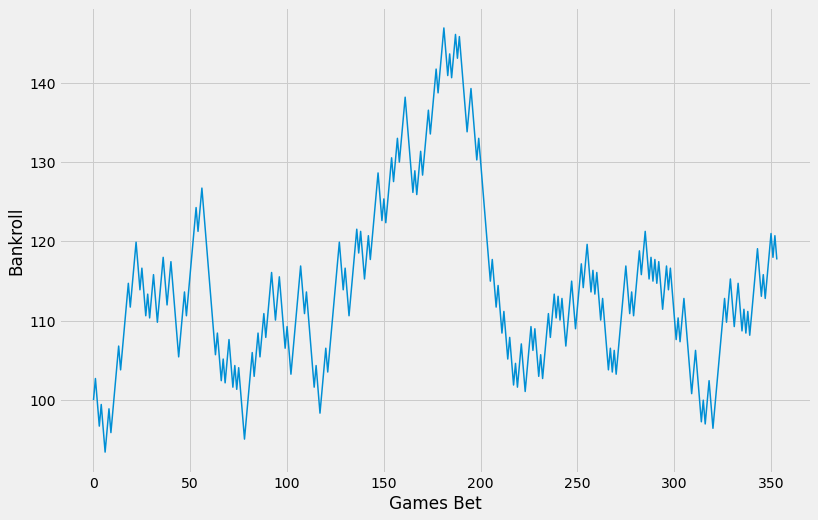

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


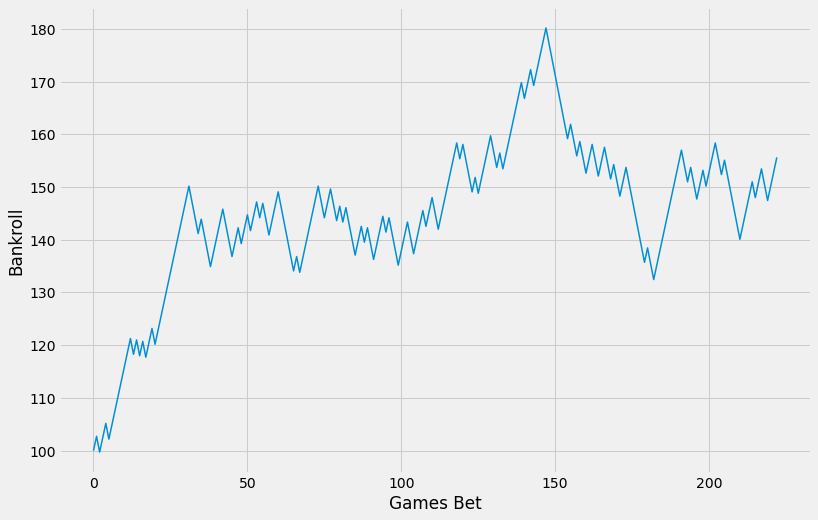

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [91]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [92]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [105]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df





In [94]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0    2021-22  1610612744               GSW   Golden State Warriors   
1    2021-22  1610612747               LAL      Los Angeles Lakers   
2    2021-22  1610612751               BKN           Brooklyn Nets   
3    2021-22  1610612749               MIL         Milwaukee Bucks   
4    2021-22  1610612766               CHA       Charlotte Hornets   
5    2021-22  1610612754               IND          Indiana Pacers   
6    2021-22  1610612741               CHI           Chicago Bulls   
7    2021-22  1610612765               DET         Detroit Pistons   
8    2021-22  1610612764               WAS      Washington Wizards   
9    2021-22  1610612761               TOR         Toronto Raptors   
10   2021-22  1610612755               PHI      Philadelphia 76ers   
11   2021-22  1610612740               NOP    New Orleans Pelicans   
12   2021-22  1610612763               MEM       Memphis Grizzlies   
13   2021-22  1610612739               CLE     Cleveland Cavaliers   
14   2021-22  1610612750               MIN  Minnesota Timberwolves   
15   2021-22  1610612745               HOU         Houston Rockets   
16   2021-22  1610612738               BOS          Boston Celtics   
17   2021-22  1610612752               NYK         New York Knicks   
18   2021-22  1610612759               SAS       San Antonio Spurs   
19   2021-22  1610612753               ORL           Orlando Magic   
20   2021-22  1610612756               PHX            Phoenix Suns   
21   2021-22  1610612743               DEN          Denver Nuggets   
22   2021-22  1610612758               SAC        Sacramento Kings   
23   2021-22  1610612757               POR  Portland Trail Blazers   
24   2021-22  1610612762               UTA               Utah Jazz   
25   2021-22  1610612760               OKC   Oklahoma City Thunder   
26   2021-22  1610612742               DAL        Dallas Mavericks   
27   2021-22  1610612737               ATL           Atlanta Hawks   
28   2021-22  1610612749               MIL         Milwaukee Bucks   
29   2021-22  1610612748               MIA              Miami Heat   
30   2021-22  1610612746               LAC             LA Clippers   
31   2021-22  1610612744               GSW   Golden State Warriors   
32   2021-22  1610612764               WAS      Washington Wizards   
33   2021-22  1610612754               IND          Indiana Pacers   
34   2021-22  1610612755               PHI      Philadelphia 76ers   
35   2021-22  1610612751               BKN           Brooklyn Nets   
36   2021-22  1610612761               TOR         Toronto Raptors   
37   2021-22  1610612738               BOS          Boston Celtics   
38   2021-22  1610612753               ORL           Orlando Magic   
39   2021-22  1610612752               NYK         New York Knicks   
40   2021-22  1610612766               CHA       Charlotte Hornets   
41   2021-22  1610612739               CLE     Cleveland Cavaliers   
42   2021-22  1610612740               NOP    New Orleans Pelicans   
43   2021-22  1610612741               CHI           Chicago Bulls   
44   2021-22  1610612760               OKC   Oklahoma City Thunder   
45   2021-22  1610612745               HOU         Houston Rockets   
46   2021-22  1610612759               SAS       San Antonio Spurs   
47   2021-22  1610612743               DEN          Denver Nuggets   
48   2021-22  1610612756               PHX            Phoenix Suns   
49   2021-22  1610612747               LAL      Los Angeles Lakers   
50   2021-22  1610612762               UTA               Utah Jazz   
51   2021-22  1610612758               SAC        Sacramento Kings   
52   2021-22  1610612737               ATL           Atlanta Hawks   
53   2021-22  1610612739               CLE     Cleveland Cavaliers   
54   2021-22  1610612754               IND          Indiana Pacers   
55   2021-22  1610612748               MIA              Miami Heat   
56   2021-22  16

In [95]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [124]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612744                    GSW   Golden State Warriors   
1       2021-22    1610612744                    GSW   Golden State Warriors   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612744                    GSW   Golden State Warriors   
4       2021-22    1610612747                    LAL      Los Angeles Lakers   
5       2021-22    1610612747                    LAL      Los Angeles Lakers   
6       2021-22    1610612747                    LAL      Los Angeles Lakers   
7       2021-22    1610612747                    LAL      Los Angeles Lakers   
8       2021-22    1610612751                    BKN           Brooklyn Nets   
9       2021-22    1610612751                    BKN           Brooklyn Nets   
10      2021-22    1610612751                    BKN           Brooklyn Nets   
11      2021-22    1610612751                    BKN           Brooklyn Nets   
12      2021-22    1610612749                    MIL         Milwaukee Bucks   
13      2021-22    1610612749                    MIL         Milwaukee Bucks   
14      2021-22    1610612749                    MIL         Milwaukee Bucks   
15      2021-22    1610612749                    MIL         Milwaukee Bucks   
16      2021-22    1610612766                    CHA       Charlotte Hornets   
17      2021-22    1610612766                    CHA       Charlotte Hornets   
18      2021-22    1610612766                    CHA       Charlotte Hornets   
19      2021-22    1610612766                    CHA       Charlotte Hornets   
20      2021-22    1610612754                    IND          Indiana Pacers   
21      2021-22    1610612754                    IND          Indiana Pacers   
22      2021-22    1610612754                    IND          Indiana Pacers   
23      2021-22    1610612754                    IND          Indiana Pacers   
24      2021-22    1610612741                    CHI           Chicago Bulls   
25      2021-22    1610612741                    CHI           Chicago Bulls   
26      2021-22    1610612741                    CHI           Chicago Bulls   
27      2021-22    1610612741                    CHI           Chicago Bulls   
28      2021-22    1610612765                    DET         Detroit Pistons   
29      2021-22    1610612765                    DET         Detroit Pistons   
30      2021-22    1610612765                    DET         Detroit Pistons   
31      2021-22    1610612764                    WAS      Washington Wizards   
32      2021-22    1610612764                    WAS      Washington Wizards   
33      2021-22    1610612764                    WAS      Washington Wizards   
34      2021-22    1610612761                    TOR         Toronto Raptors   
35      2021-22    1610612761                    TOR         Toronto Raptors   
36      2021-22    1610612761                    TOR         Toronto Raptors   
37      2021-22    1610612761                    TOR         Toronto Raptors   
38      2021-22    1610612755                    PHI      Philadelphia 76ers   
39      2021-22    1610612755                    PHI      Philadelphia 76ers   
40      2021-22    1610612755                    PHI      Philadelphia 76ers   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612740                    NOP    New Orleans Pelicans   
44      2021-22    1610612740                    NOP    New Orleans Pelicans   
45      2021-22    1610612740                    NOP    New Orleans Pelicans   
46      2021-22    1610612763                    MEM       Memphis Grizzlies   
47      2021-22    1610612763                    MEM       Memphis Grizzlies   
48      2021-22    1610612763                    MEM       Memphis Grizzlies   
49  

In [96]:
from datetime import date
date.today()

datetime.date(2021, 10, 29)

In [97]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


In [98]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=elo_final_2020.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [251]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612751                    BKN           Brooklyn Nets   
1       2021-22    1610612749                    MIL         Milwaukee Bucks   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612747                    LAL      Los Angeles Lakers   
4       2021-22    1610612754                    IND          Indiana Pacers   
5       2021-22    1610612766                    CHA       Charlotte Hornets   
6       2021-22    1610612741                    CHI           Chicago Bulls   
7       2021-22    1610612765                    DET         Detroit Pistons   
8       2021-22    1610612738                    BOS          Boston Celtics   
9       2021-22    1610612752                    NYK         New York Knicks   
10      2021-22    1610612764                    WAS      Washington Wizards   
11      2021-22    1610612761                    TOR         Toronto Raptors   
12      2021-22    1610612739                    CLE     Cleveland Cavaliers   
13      2021-22    1610612763                    MEM       Memphis Grizzlies   
14      2021-22    1610612745                    HOU         Houston Rockets   
15      2021-22    1610612750                    MIN  Minnesota Timberwolves   
16      2021-22    1610612755                    PHI      Philadelphia 76ers   
17      2021-22    1610612740                    NOP    New Orleans Pelicans   
18      2021-22    1610612753                    ORL           Orlando Magic   
19      2021-22    1610612759                    SAS       San Antonio Spurs   
20      2021-22    1610612760                    OKC   Oklahoma City Thunder   
21      2021-22    1610612762                    UTA               Utah Jazz   
22      2021-22    1610612743                    DEN          Denver Nuggets   
23      2021-22    1610612756                    PHX            Phoenix Suns   
24      2021-22    1610612758                    SAC        Sacramento Kings   
25      2021-22    1610612757                    POR  Portland Trail Blazers   
26      2021-22    1610612742                    DAL        Dallas Mavericks   
27      2021-22    1610612737                    ATL           Atlanta Hawks   
28      2021-22    1610612749                    MIL         Milwaukee Bucks   
29      2021-22    1610612748                    MIA              Miami Heat   
30      2021-22    1610612746                    LAC             LA Clippers   
31      2021-22    1610612744                    GSW   Golden State Warriors   
32      2021-22    1610612766                    CHA       Charlotte Hornets   
33      2021-22    1610612739                    CLE     Cleveland Cavaliers   
34      2021-22    1610612752                    NYK         New York Knicks   
35      2021-22    1610612753                    ORL           Orlando Magic   
36      2021-22    1610612754                    IND          Indiana Pacers   
37      2021-22    1610612764                    WAS      Washington Wizards   
38      2021-22    1610612761                    TOR         Toronto Raptors   
39      2021-22    1610612738                    BOS          Boston Celtics   
40      2021-22    1610612751                    BKN           Brooklyn Nets   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612741                    CHI           Chicago Bulls   
44      2021-22    1610612760                    OKC   Oklahoma City Thunder   
45      2021-22    1610612745                    HOU         Houston Rockets   
46      2021-22    1610612759                    SAS       San Antonio Spurs   
47      2021-22    1610612743                    DEN          Denver Nuggets   
48      2021-22    1610612756                    PHX            Phoenix Suns   
49  

In [100]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread, home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
    home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
    away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
    new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = away_spread 
    diffs.at[1, 'SPREAD_team'] = home_spread
    
    diffs.at[0, 'ML_team'] = away_ml
    diffs.at[1, 'ML_team'] = home_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


### Make Predictions

In [102]:

def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_spreads = get_days_spreads(todays_date)
    todays_spreads = clean_spreads_df(todays_spreads)

    todays_mls = get_days_moneylines(todays_date)
    todays_mls = clean_moneyline_df(todays_mls)
    
    todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['HOME_TEAM']
        away_team = row['AWAY_TEAM']
        home_spread = row['HIGHEST_HOME_SPREAD'] 
        away_spread = row['HIGHEST_AWAY_SPREAD']
        home_ml = row['HIGHEST_HOME_ML']
        away_ml = row['HIGHEST_AWAY_ML']
        game_date = row['GM_DATE']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [121]:
# X_full = pd.concat([X_train, X_test])
# y_full = pd.concat([y_train, y_test])

# X_full.shape, y_full.shape

# estimators = [('log', best_lr), ('sgd', best_sgd),
#               ('svc', best_svc), ('lgbc', best_lgbc),
#              ('rf', best_rf), ('knn', best_knn)]


# final_stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
#                                  n_jobs=-1, verbose=1)


# final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model'

joblib.dump(final_stacked_clf, filename)

['../models/finalized_stacked_model']

In [108]:
X_train

RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [123]:
final_stacked_model = joblib.load('../models/finalized_stacked_model')


final_stacked_model.predict(X_train)

array([1, 0, 0, ..., 1, 1, 0])

In [126]:
def main(conn, season, model, prev_season_elo):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [127]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/final_elo_ratings_2020")
todays_predictions = main(connection, 2021, final_stacked_clf, prev_season_elo)

connection.close()

todays_predictions

progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]
progress:: 154it [00:00, 4529.64it/s]


game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-30       WAS       BOS         -4.0          0.506587   
1   2021-10-30       DET       ORL         -8.0          0.520615   
2   2021-10-30       NOP       NYK          6.0          0.446485   
3   2021-10-30       IND       TOR         -4.5          0.467039   
4   2021-10-30       PHI       ATL         -5.5          0.557671   
5   2021-10-30       CHI       UTA          4.5          0.501391   
6   2021-10-30       MIL       SAS         -7.0          0.494550   
7   2021-10-30       MEM       MIA         -3.0          0.500480   
8   2021-10-30       GSW       OKC        -14.5          0.530507   
9   2021-10-30       MIN       DEN         -3.0          0.551326   
10  2021-10-30       PHX       CLE        -10.0          0.569496   

    away_cover_probs  home_cover_avg  
0           0.499518        0.503535  
1           0.471622        0.524496  
2           0.550445        0.448020  
3           0.532006        0.467516  
4           0.442400        0.557636  
5           0.500978        0.500206  
6           0.509464        0.492543  
7           0.500311        0.500085  
8           0.472792        0.528858  
9           0.451358        0.549984  
10          0.431999        0.568748

In [117]:
todays_predictions.to_csv("../test_data.csv", index=False)

In [118]:
todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)

In [119]:
pd.read_csv('../test_data.csv')

game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-29       TOR       ORL         -9.0          0.589156   
1   2021-10-29       MIA       CHA         -8.5          0.502124   
2   2021-10-29       BKN       IND        -10.5          0.503996   
3   2021-10-29       NOP       SAC          3.5          0.433964   
4   2021-10-29       POR       LAC         -5.5          0.481502   
5   2021-10-29       DEN       DAL         -3.5          0.511928   
6   2021-10-29       LAL       CLE         -8.5          0.485542   
7   2021-10-29       TOR       ORL         -9.0          0.589156   
8   2021-10-29       MIA       CHA         -8.5          0.502124   
9   2021-10-29       BKN       IND        -10.5          0.503996   
10  2021-10-29       NOP       SAC          3.5          0.433964   
11  2021-10-29       POR       LAC         -5.5          0.481502   
12  2021-10-29       DEN       DAL         -3.5          0.511928   
13  2021-10-29       LAL       CLE         -8.5          0.485542   

    away_cover_probs  home_cover_avg  
0           0.413940        0.587608  
1           0.490751        0.505686  
2           0.496721        0.503638  
3           0.561797        0.436084  
4           0.523630        0.478936  
5           0.489419        0.511255  
6           0.509621        0.487960  
7           0.413940        0.587608  
8           0.490751        0.505686  
9           0.496721        0.503638  
10          0.561797        0.436084  
11          0.523630        0.478936  
12          0.489419        0.511255  
13          0.509621        0.487960

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df